# 0. 라이브러리

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
    confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, r2_score
)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Activation, Flatten, Dropout, Reshape,
    Conv1D, MaxPooling1D, Conv2D, MaxPooling2D,
    SimpleRNN, Bidirectional, LSTM, GRU
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import holidays
from datetime import timedelta

In [2]:
# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. ML(RandomForest, XGBoost, LightGBM)

## 함수

### 데이터 전처리 함수

In [36]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['운행년월'] = pd.to_datetime(df['운행년월'], format='%Y-%m')
    
    # 다양한 선로에 대해 처리
    lines = ['경부선', '경전선', '동해선', '전라선', '호남선']
    dfs = {}
    
    for line in lines:
        df_line = df[df['주운행선'] == line].copy()
        df_line['승차인원수_T1'] = df_line['승차인원수'].shift(1)
        df_line['승차인원수_T2'] = df_line['승차인원수'].shift(2)
        df_line.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)
        
        train_data = df_line[(df_line['운행년월'] >= '2015-01-01') & (df_line['운행년월'] <= '2023-03-31')]
        val_data = df_line[(df_line['운행년월'] >= '2023-04-01') & (df_line['운행년월'] <= '2024-03-31')]
        
        features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '공급대비승차율', '승차인원수_T1', '승차인원수_T2']
        
        X_train = train_data[features].dropna()
        Y_train = train_data.loc[X_train.index, '승차인원수']
        X_val = val_data[features].dropna()
        Y_val = val_data.loc[X_val.index, '승차인원수']
        
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        
        dfs[line] = {
            'X_train_scaled': X_train_scaled,
            'Y_train': Y_train,
            'X_val_scaled': X_val_scaled,
            'Y_val': Y_val,
            'train_data': train_data,
            'val_data': val_data
        }
    
    return dfs

### 모델 훈련 및 평가 함수

In [38]:
#랜덤포레스트
def model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        min_samples_split=int(best_hyperparams['min_samples_split']),
        min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
        max_features=best_hyperparams['max_features'],
        bootstrap=best_hyperparams['bootstrap'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results
    
#LightGBM
def model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val):
    lgb_model = lgb.LGBMRegressor(random_state=0)

    lgb_model.fit(X_train_scaled, Y_train)

    Y_train_pred_lgb = lgb_model.predict(X_train_scaled)
    train_r_squared_lgb = r2_score(Y_train, Y_train_pred_lgb)
    train_mae_lgb = mean_absolute_error(Y_train, Y_train_pred_lgb)
    train_mse_lgb = mean_squared_error(Y_train, Y_train_pred_lgb)
    train_mape_lgb = np.mean(np.abs((Y_train - Y_train_pred_lgb) / Y_train)) * 100

    Y_val_pred_lgb = lgb_model.predict(X_val_scaled)
    val_r_squared_lgb = r2_score(Y_val, Y_val_pred_lgb)
    val_mae_lgb = mean_absolute_error(Y_val, Y_val_pred_lgb)
    val_mse_lgb = mean_squared_error(Y_val, Y_val_pred_lgb)
    val_mape_lgb = np.mean(np.abs((Y_val - Y_val_pred_lgb) / Y_val)) * 100

    results = {
        'train_metrics': {
            'r_squared': train_r_squared_lgb,
            'mae': train_mae_lgb,
            'mse': train_mse_lgb,
            'mape': train_mape_lgb
        },
        'val_metrics': {
            'r_squared': val_r_squared_lgb,
            'mae': val_mae_lgb,
            'mse': val_mse_lgb,
            'mape': val_mape_lgb
        }
    }
    return lgb_model, results

### 시각화 함수

In [39]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred, line_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title(f'Train - {line_name}')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title(f'Val - {line_name}')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

## RandomForest



--- 경부선 모델 학습 및 평가 ---

100%|███████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26trial/s, best loss: 131591.8968533304]
Random Forest 모델의 최적 하이퍼파라미터:
{'bootstrap': 0, 'max_depth': 8.0, 'max_features': 0.9485150158466052, 'min_samples_leaf': 6.0, 'min_samples_split': 7.0, 'n_estimators': 230.0}
Random Forest(Train):
R-squared: 0.94
MAE: 110292.32
MSE: 28916943362.93
MAPE: 4.79%

Random Forest(Val):
R-squared: -1.49
MAE: 166684.78
MSE: 44831149185.15
MAPE: 4.74%


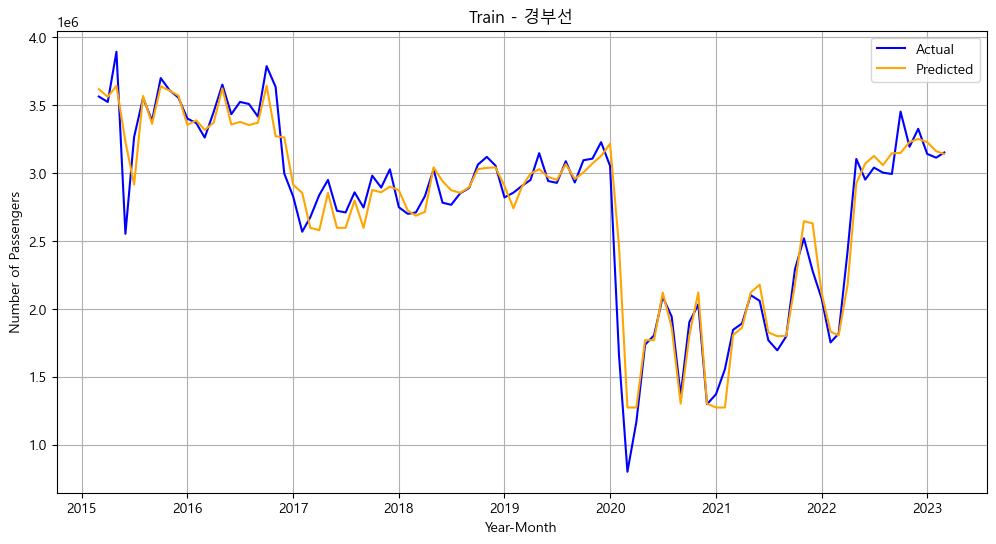

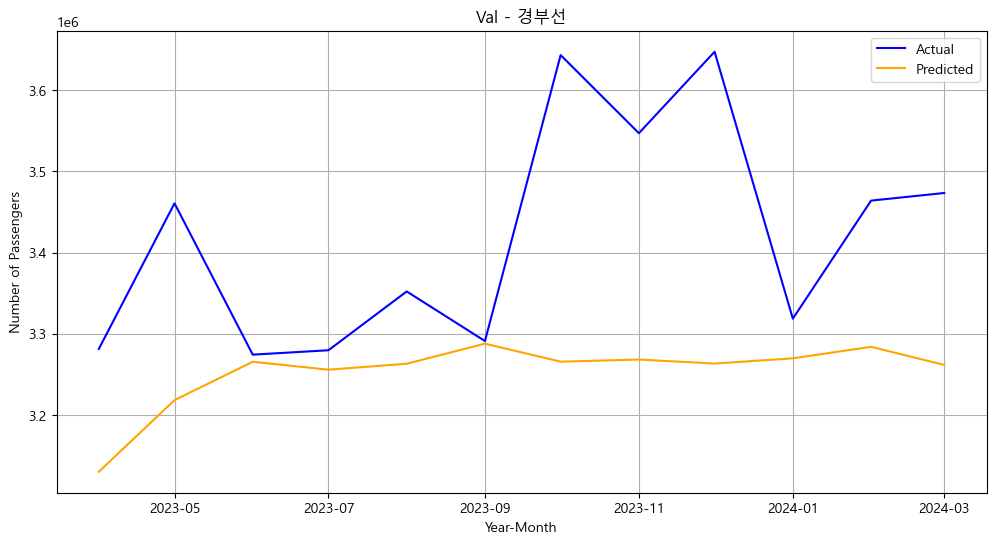



--- 경전선 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57trial/s, best loss: 27051.263181818667]
Random Forest 모델의 최적 하이퍼파라미터:
{'bootstrap': 1, 'max_depth': 6.0, 'max_features': 0.9291608780443953, 'min_samples_leaf': 4.0, 'min_samples_split': 6.0, 'n_estimators': 220.0}
Random Forest(Train):
R-squared: 0.91
MAE: 19190.97
MSE: 989350564.94
MAPE: 4.86%

Random Forest(Val):
R-squared: -2.45
MAE: 41781.22
MSE: 2271276359.35
MAPE: 6.01%


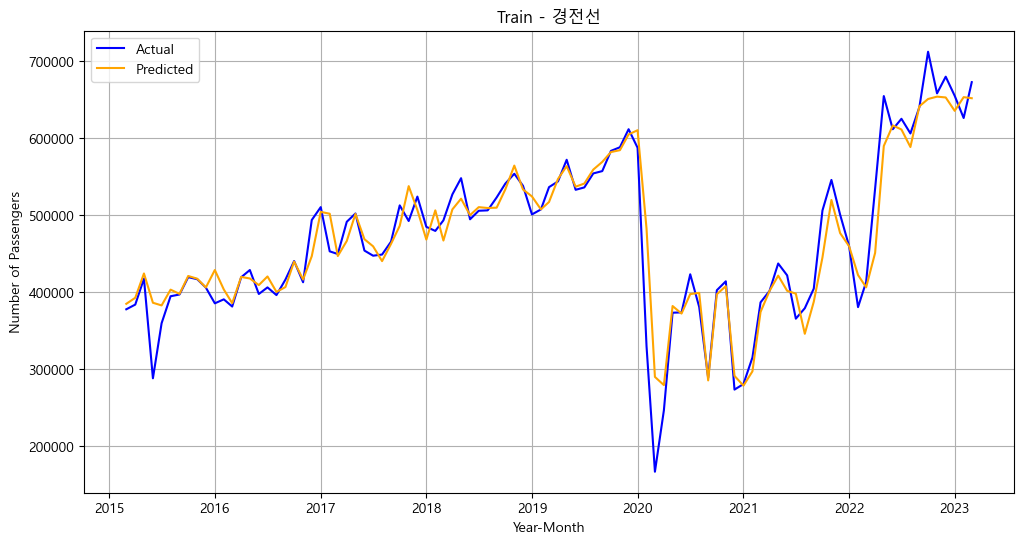

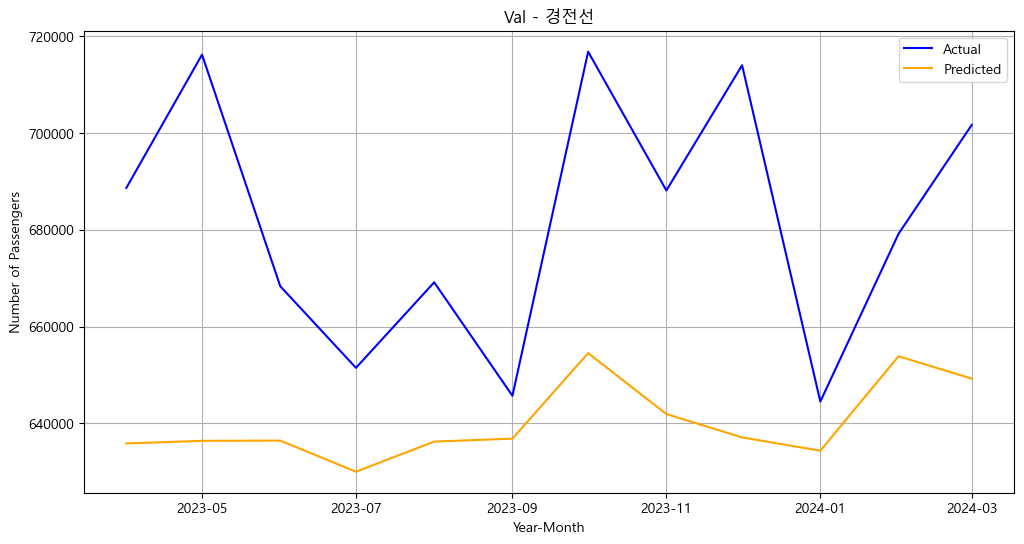



--- 동해선 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11trial/s, best loss: 26587.293981481518]
Random Forest 모델의 최적 하이퍼파라미터:
{'bootstrap': 1, 'max_depth': 7.0, 'max_features': 0.9451947078412652, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 180.0}
Random Forest(Train):
R-squared: 0.87
MAE: 19649.28
MSE: 857785681.88
MAPE: 4.75%

Random Forest(Val):
R-squared: -2.22
MAE: 29624.27
MSE: 1183162386.50
MAPE: 5.01%


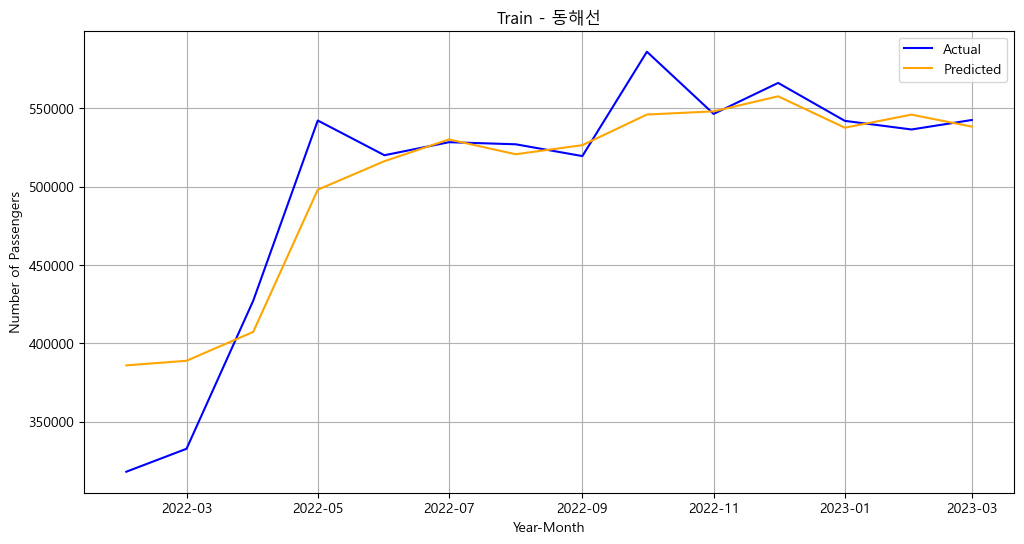

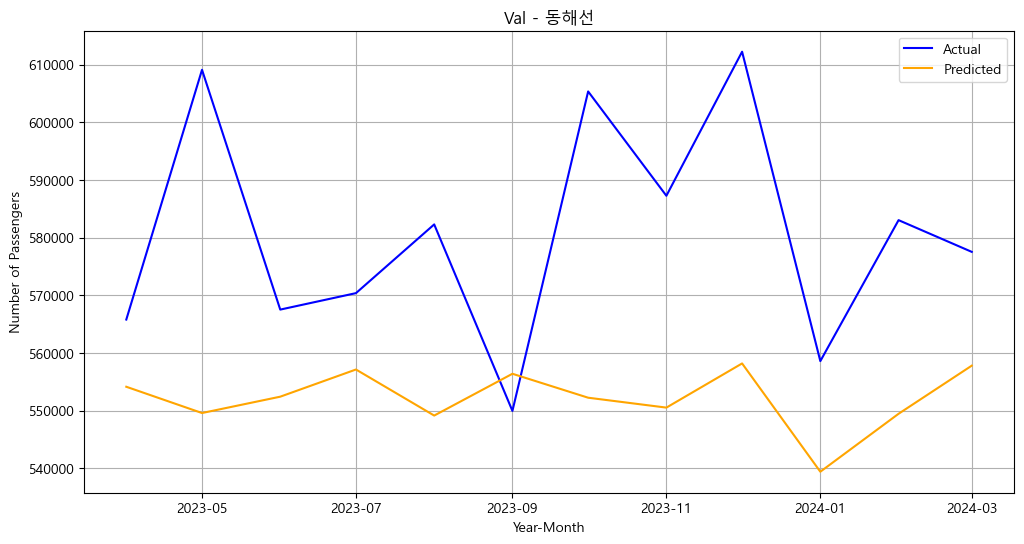



--- 전라선 모델 학습 및 평가 ---

100%|████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51trial/s, best loss: 66726.9692857116]
Random Forest 모델의 최적 하이퍼파라미터:
{'bootstrap': 1, 'max_depth': 27.0, 'max_features': 0.9395440059504815, 'min_samples_leaf': 6.0, 'min_samples_split': 4.0, 'n_estimators': 280.0}
Random Forest(Train):
R-squared: 0.91
MAE: 28412.97
MSE: 1686794879.01
MAPE: 7.46%

Random Forest(Val):
R-squared: -2.73
MAE: 81867.76
MSE: 8064661157.47
MAPE: 10.62%


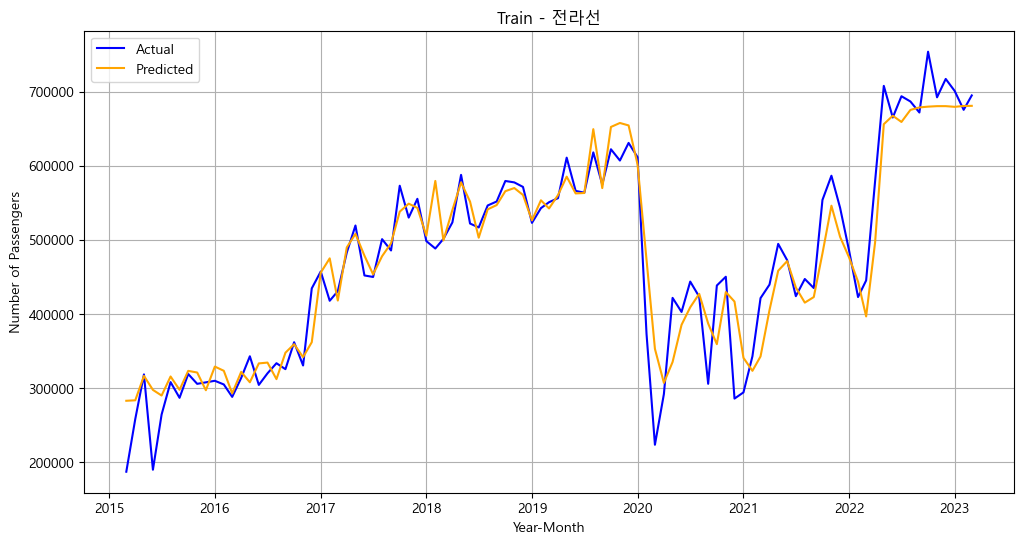

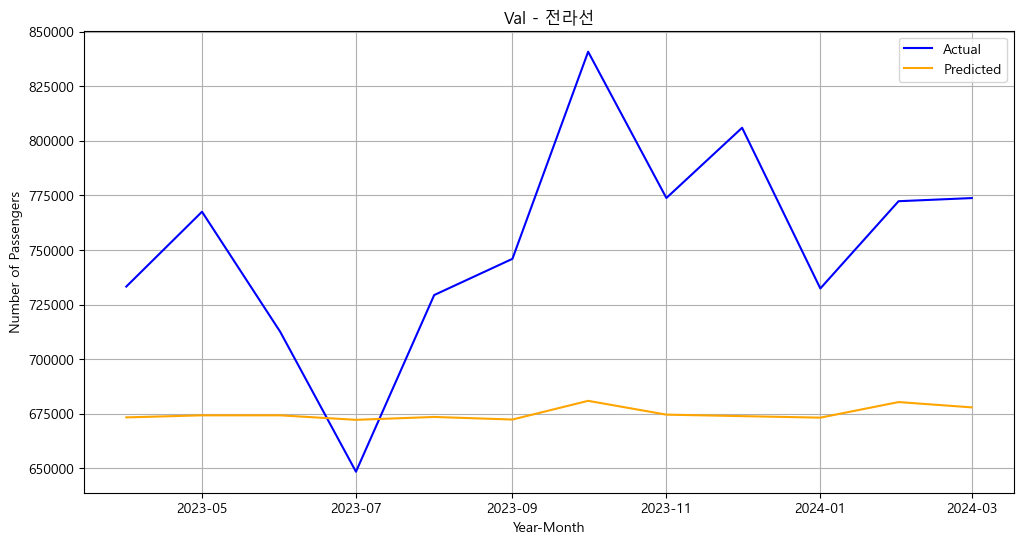



--- 호남선 모델 학습 및 평가 ---

100%|███████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56trial/s, best loss: 32275.17805805686]
Random Forest 모델의 최적 하이퍼파라미터:
{'bootstrap': 1, 'max_depth': 6.0, 'max_features': 0.7621288091341537, 'min_samples_leaf': 2.0, 'min_samples_split': 9.0, 'n_estimators': 290.0}
Random Forest(Train):
R-squared: 0.95
MAE: 26602.42
MSE: 1237018722.94
MAPE: 3.74%

Random Forest(Val):
R-squared: -1.01
MAE: 48383.39
MSE: 3342840493.23
MAPE: 4.63%


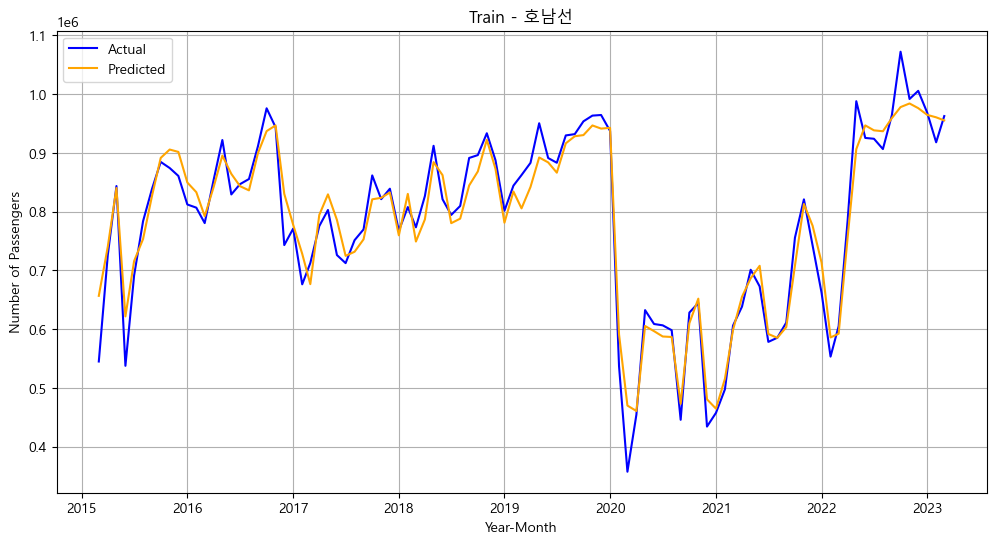

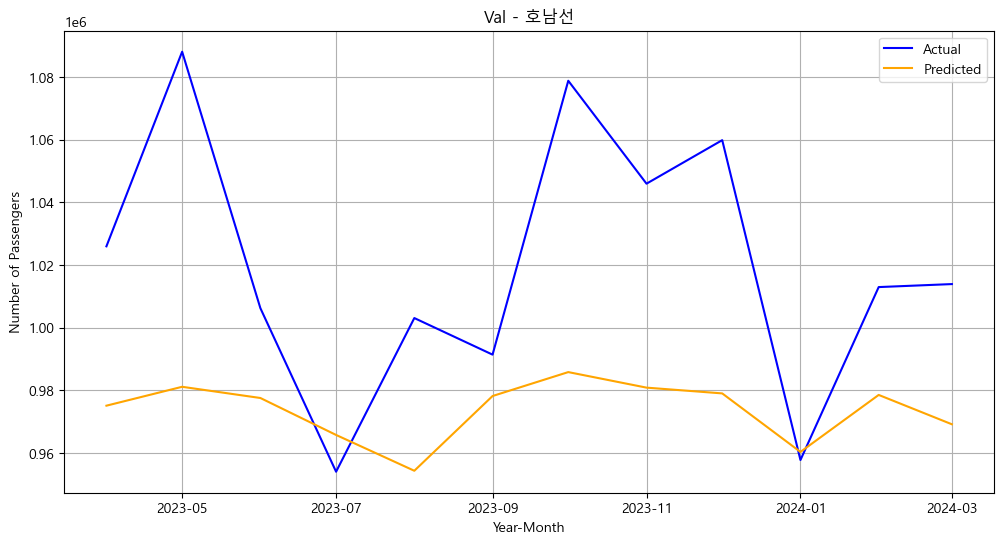

In [40]:
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
data_dict = preprocess_data(file_path)

for line_name, data in data_dict.items():
    print(f'\n\n--- {line_name} 모델 학습 및 평가 ---\n')
    
    X_train_scaled = data['X_train_scaled']
    Y_train = data['Y_train']
    X_val_scaled = data['X_val_scaled']
    Y_val = data['Y_val']
    train_data = data['train_data']
    val_data = data['val_data']
    
    best_rf_model, rf_results = model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
    print("Random Forest 모델의 최적 하이퍼파라미터:")
    print(rf_results['best_hyperparams'])
    print('Random Forest(Train):')
    print(f"R-squared: {rf_results['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {rf_results['train_metrics']['mae']:.2f}")
    print(f"MSE: {rf_results['train_metrics']['mse']:.2f}")
    print(f"MAPE: {rf_results['train_metrics']['mape']:.2f}%")
    print()
    print('Random Forest(Val):')
    print(f"R-squared: {rf_results['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {rf_results['val_metrics']['mae']:.2f}")
    print(f"MSE: {rf_results['val_metrics']['mse']:.2f}")
    print(f"MAPE: {rf_results['val_metrics']['mape']:.2f}%")
    
    Y_train_pred_rf = best_rf_model.predict(X_train_scaled)
    Y_val_pred_rf = best_rf_model.predict(X_val_scaled)
    
    plot_results(train_data, val_data, Y_train, Y_train_pred_rf, Y_val, Y_val_pred_rf, line_name)

## XGBoost



--- 경부선 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 113207.97916666667]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.9964868182166448, 'gamma': 0.23016336963069112, 'learning_rate': 0.2733623842366027, 'max_depth': 3.0, 'n_estimators': 120.0, 'reg_alpha': 0.7331919885177685, 'reg_lambda': 0.6065681015520038, 'subsample': 0.8115134063800111}
XGBoost(Train):
R-squared: 1.00
MAE: 2111.18
MSE: 7377003.15
MAPE: 0.08%

XGBoost(Val):
R-squared: -0.25
MAE: 113207.98
MSE: 22438107827.16
MAPE: 3.26%


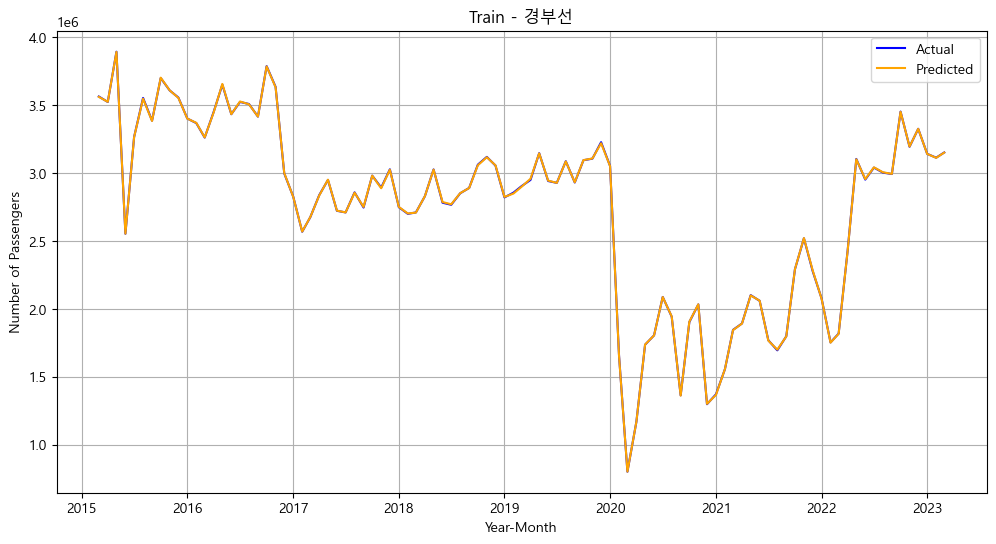

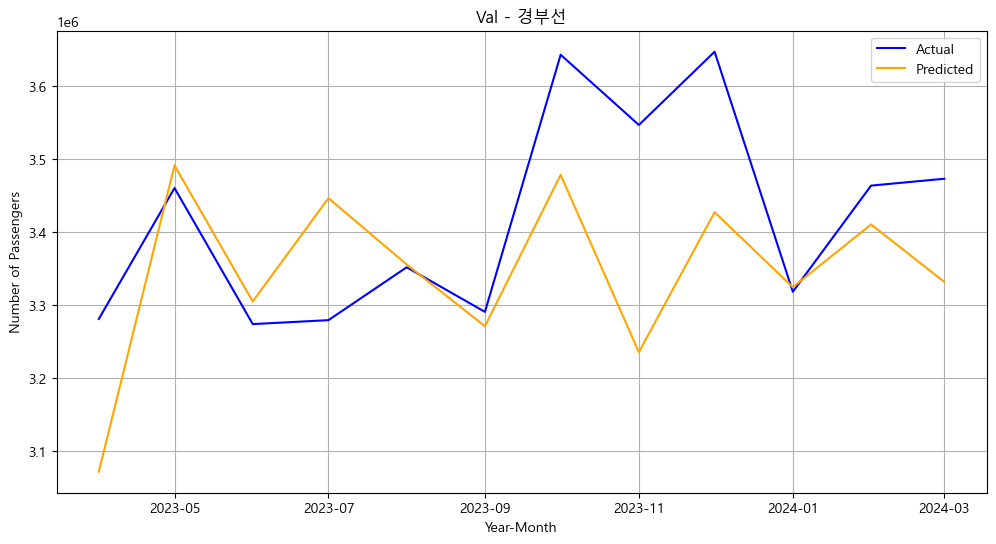



--- 경전선 모델 학습 및 평가 ---

100%|████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15trial/s, best loss: 25906.078125]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.842461406383838, 'gamma': 0.08650159761769152, 'learning_rate': 0.24604220700025511, 'max_depth': 5.0, 'n_estimators': 300.0, 'reg_alpha': 0.005165592614932837, 'reg_lambda': 0.005686680817423793, 'subsample': 0.8502721814182436}
XGBoost(Train):
R-squared: 1.00
MAE: 0.13
MSE: 0.02
MAPE: 0.00%

XGBoost(Val):
R-squared: -0.72
MAE: 25906.08
MSE: 1129672355.95
MAPE: 3.70%


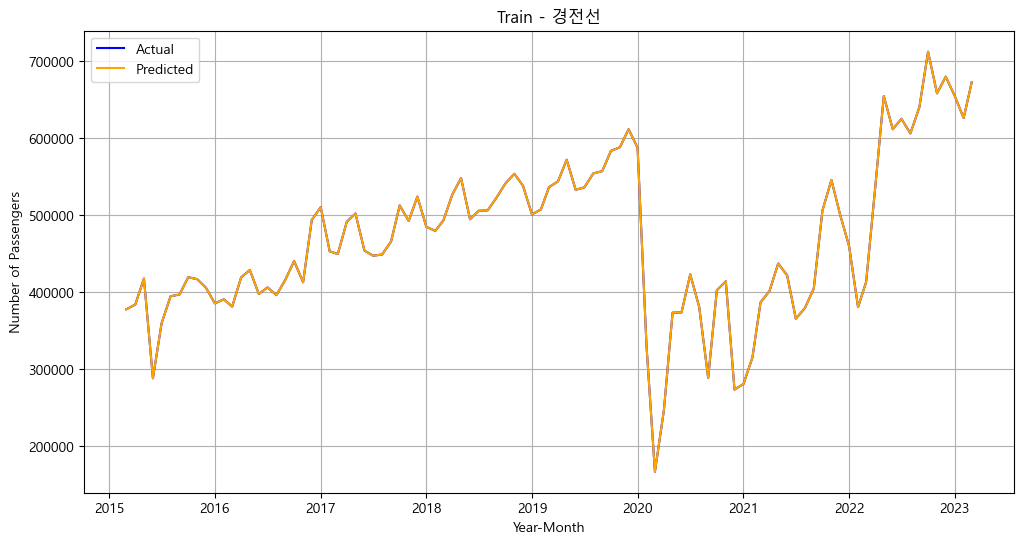

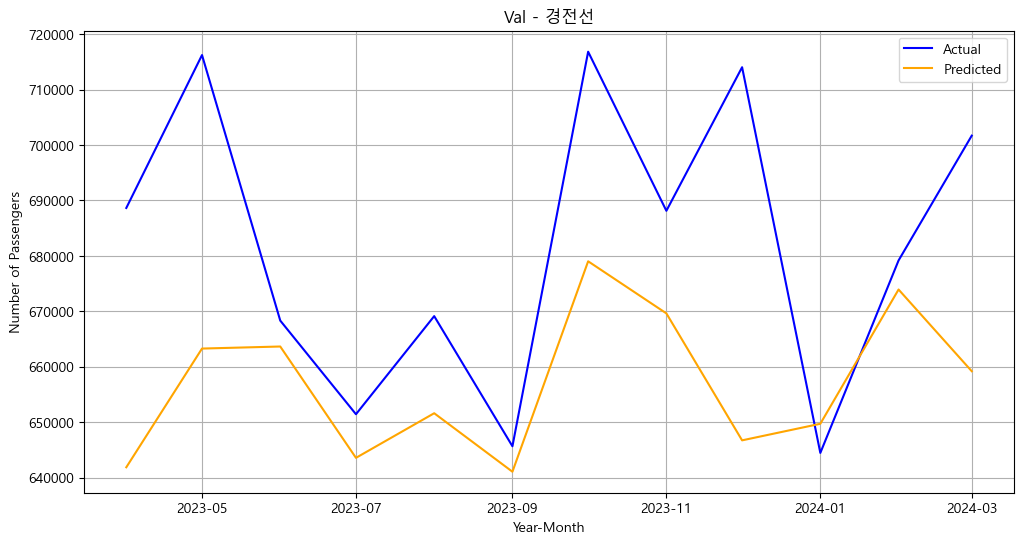



--- 동해선 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57trial/s, best loss: 25145.645833333332]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.7180265232459373, 'gamma': 0.38701878423478786, 'learning_rate': 0.2876575198795939, 'max_depth': 13.0, 'n_estimators': 140.0, 'reg_alpha': 0.0779210032928432, 'reg_lambda': 0.7650375609809231, 'subsample': 0.7897180186833707}
XGBoost(Train):
R-squared: 1.00
MAE: 0.26
MSE: 0.11
MAPE: 0.00%

XGBoost(Val):
R-squared: -1.35
MAE: 25145.65
MSE: 864309272.47
MAPE: 4.26%


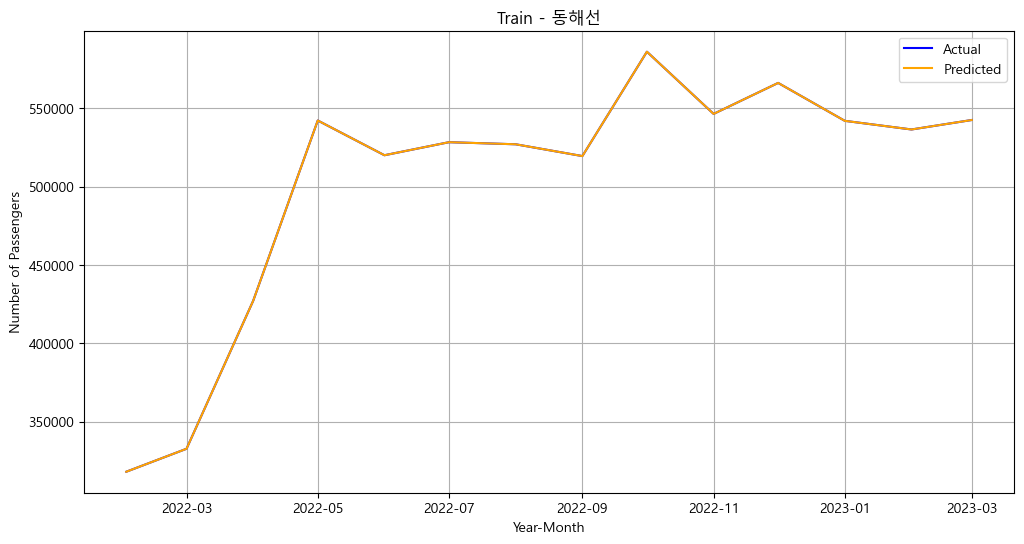

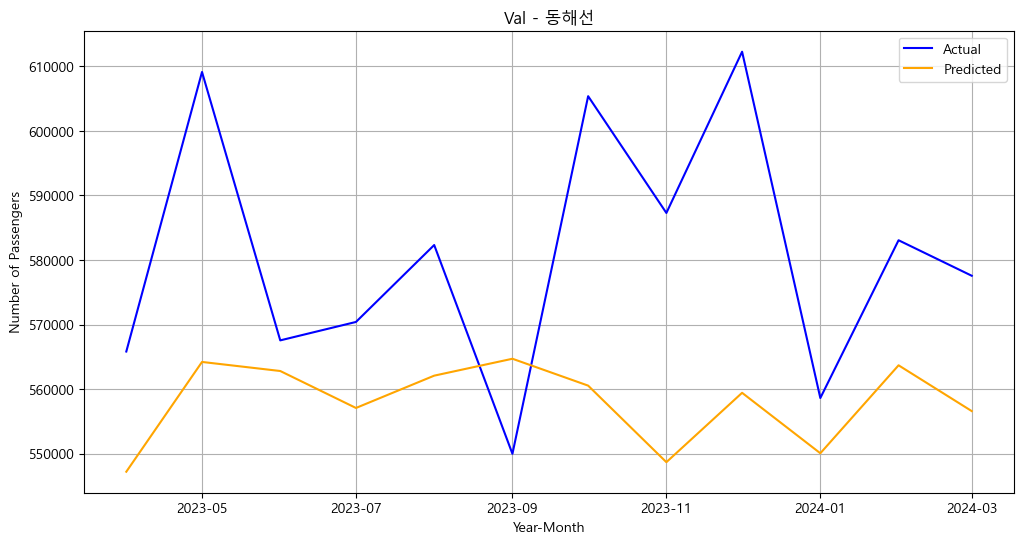



--- 전라선 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10trial/s, best loss: 61719.494791666664]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.7954675769926014, 'gamma': 0.08120750833256718, 'learning_rate': 0.27197149503602164, 'max_depth': 11.0, 'n_estimators': 210.0, 'reg_alpha': 0.6582329499811502, 'reg_lambda': 0.8323998093024316, 'subsample': 0.7187388039497026}
XGBoost(Train):
R-squared: 1.00
MAE: 0.20
MSE: 0.07
MAPE: 0.00%

XGBoost(Val):
R-squared: -1.11
MAE: 61719.49
MSE: 4550923070.76
MAPE: 8.02%


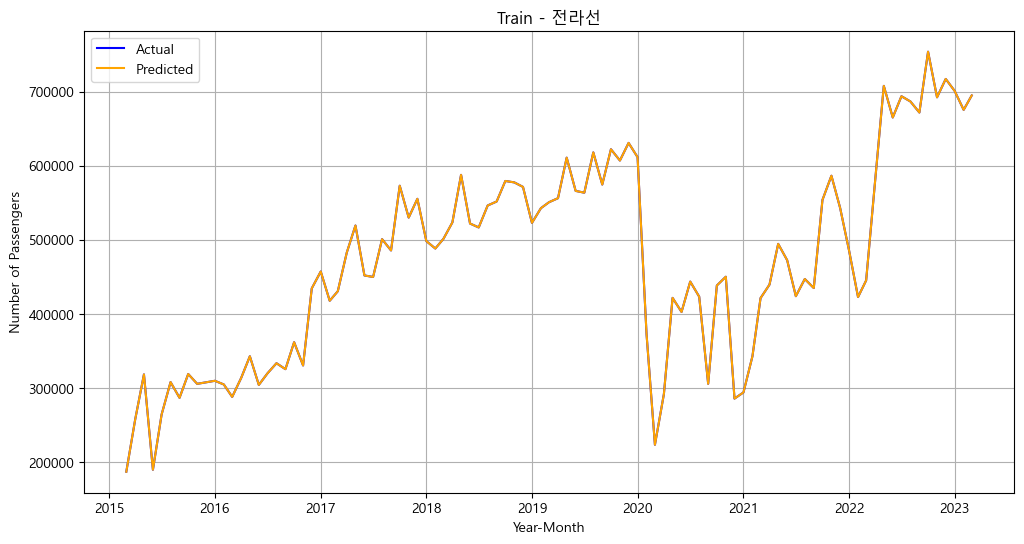

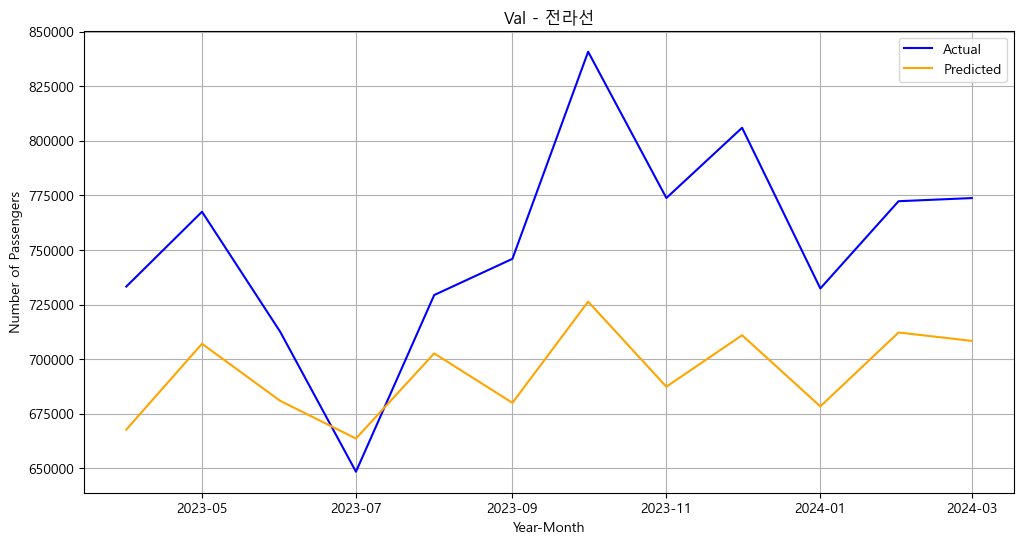



--- 호남선 모델 학습 및 평가 ---

100%|████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/trial, best loss: 33683.640625]
XGBoost 모델의 최적 하이퍼파라미터:
{'colsample_bytree': 0.8527939837021702, 'gamma': 0.13148648992551035, 'learning_rate': 0.2878268952613408, 'max_depth': 3.0, 'n_estimators': 280.0, 'reg_alpha': 0.2658872181664398, 'reg_lambda': 0.9232073911470662, 'subsample': 0.7391432760203768}
XGBoost(Train):
R-squared: 1.00
MAE: 10.18
MSE: 177.57
MAPE: 0.00%

XGBoost(Val):
R-squared: 0.11
MAE: 33683.64
MSE: 1488733980.93
MAPE: 3.29%


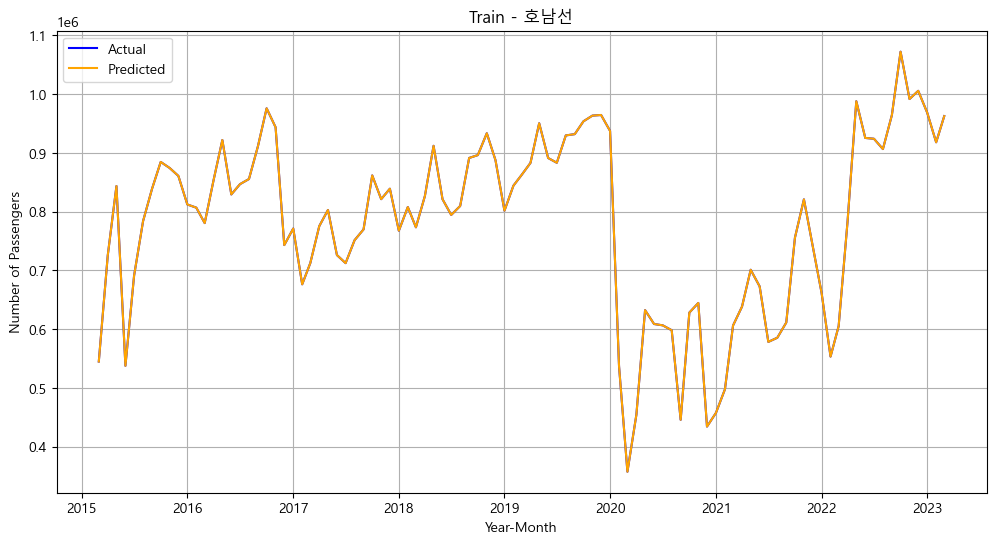

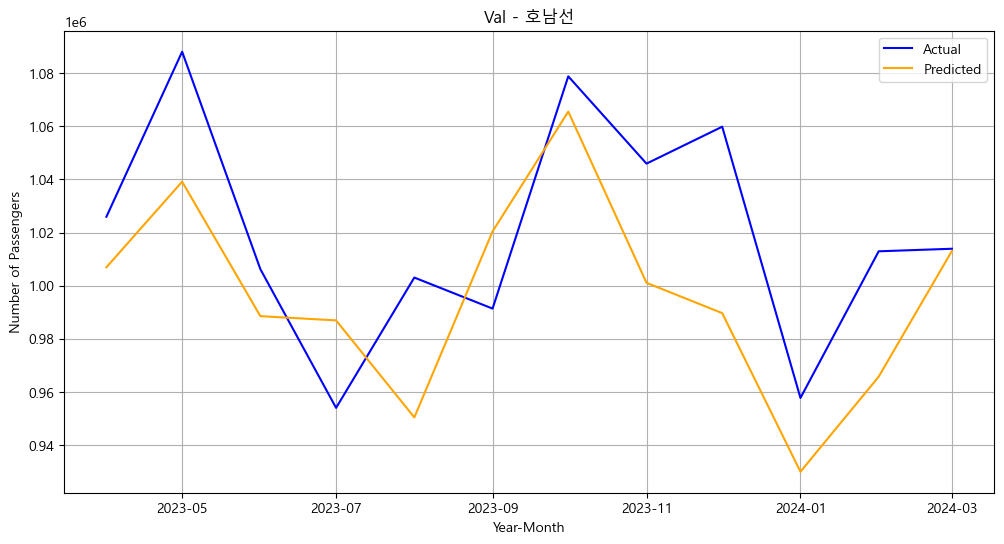

In [14]:
for line_name, data in data_dict.items():
    print(f'\n\n--- {line_name} 모델 학습 및 평가 ---\n')
    
    X_train_scaled = data['X_train_scaled']
    Y_train = data['Y_train']
    X_val_scaled = data['X_val_scaled']
    Y_val = data['Y_val']
    train_data = data['train_data']
    val_data = data['val_data']
    
    best_xgb_model, xgb_results = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
    print("XGBoost 모델의 최적 하이퍼파라미터:")
    print(xgb_results['best_hyperparams'])
    print('XGBoost(Train):')
    print(f"R-squared: {xgb_results['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {xgb_results['train_metrics']['mae']:.2f}")
    print(f"MSE: {xgb_results['train_metrics']['mse']:.2f}")
    print(f"MAPE: {xgb_results['train_metrics']['mape']:.2f}%")
    print()
    print('XGBoost(Val):')
    print(f"R-squared: {xgb_results['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {xgb_results['val_metrics']['mae']:.2f}")
    print(f"MSE: {xgb_results['val_metrics']['mse']:.2f}")
    print(f"MAPE: {xgb_results['val_metrics']['mape']:.2f}%")
    
    Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
    Y_val_pred_xgb = best_xgb_model.predict(X_val_scaled)
    
    plot_results(train_data, val_data, Y_train, Y_train_pred_xgb, Y_val, Y_val_pred_xgb, line_name)

## LightGBM



--- 경부선 모델 학습 및 평가 ---

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 7
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

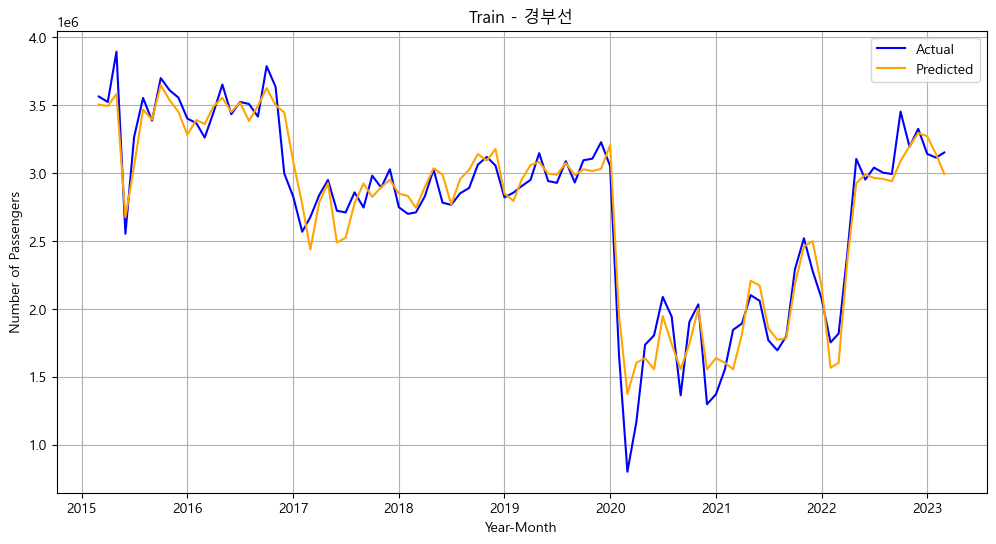

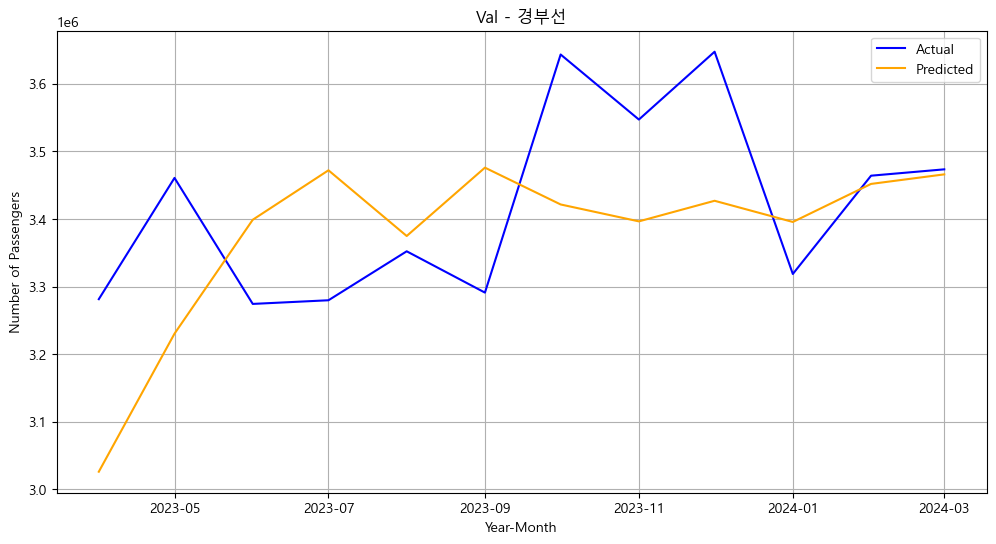



--- 경전선 모델 학습 및 평가 ---

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 7
[LightGBM] [Info] Start training from score 469721.103093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

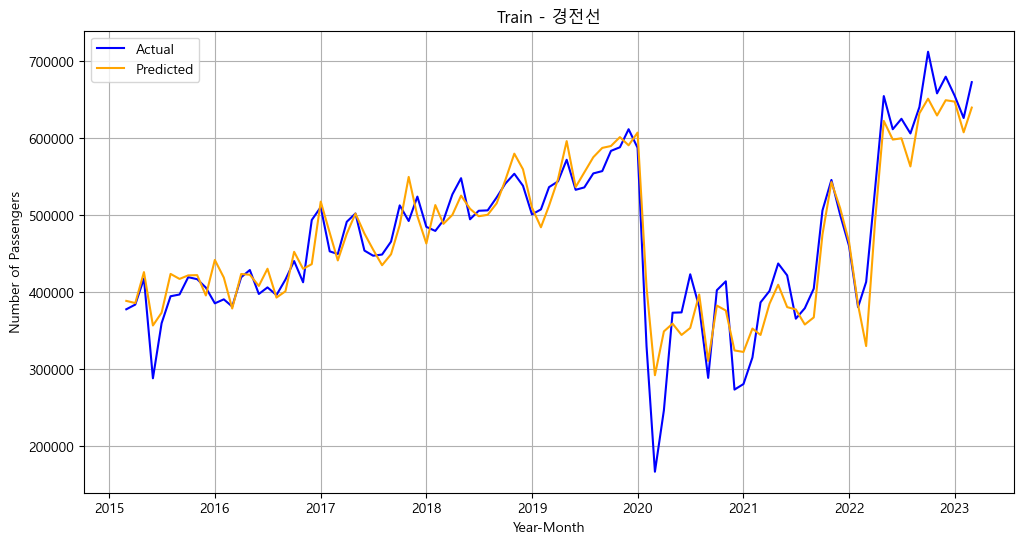

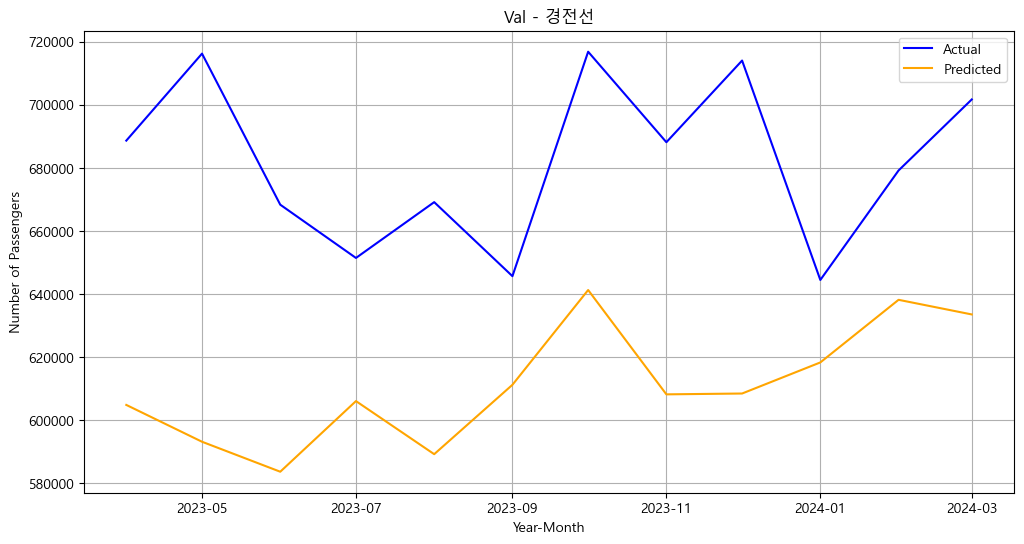



--- 동해선 모델 학습 및 평가 ---

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 14, number of used features: 0
[LightGBM] [Info] Start training from score 502504.357143
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

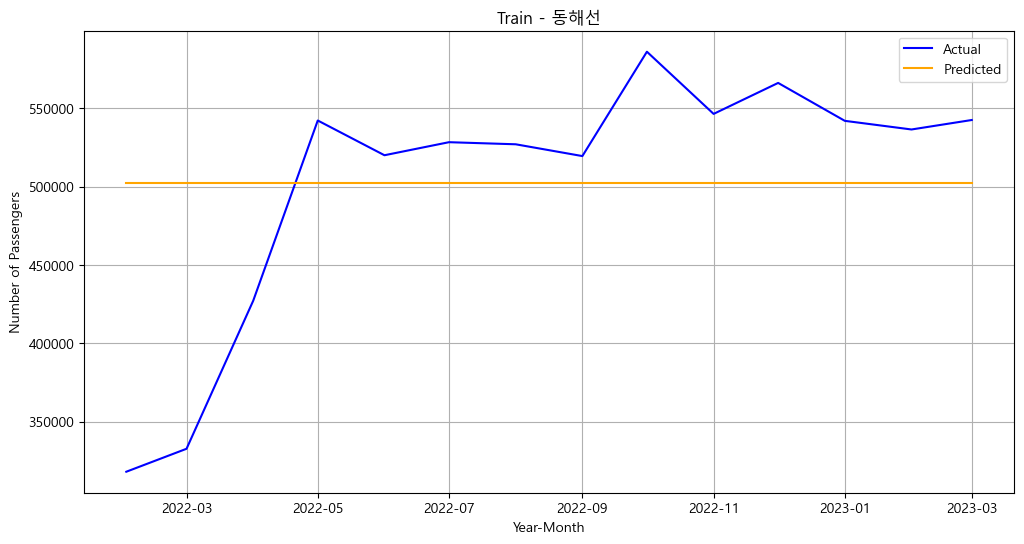

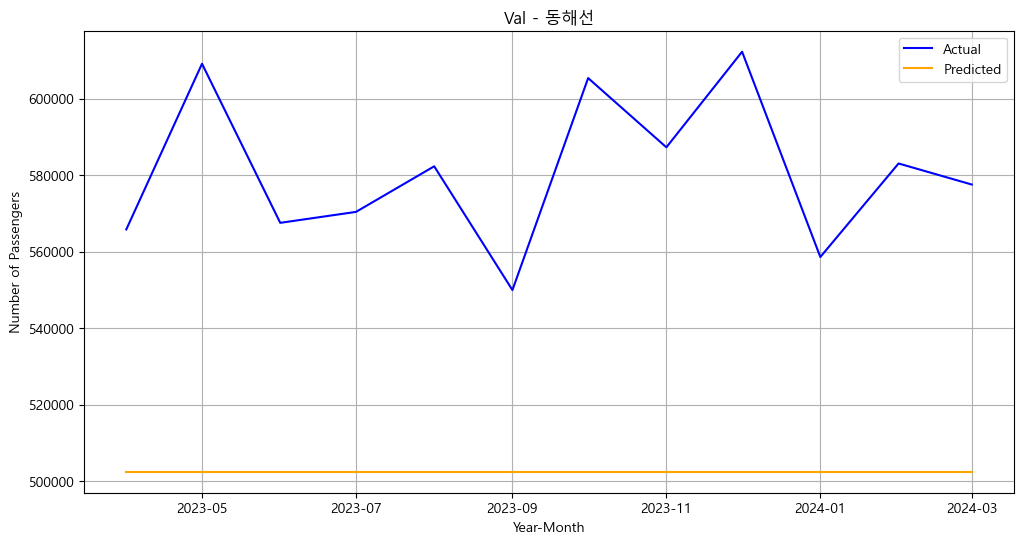



--- 전라선 모델 학습 및 평가 ---

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 7
[LightGBM] [Info] Start training from score 471375.938144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

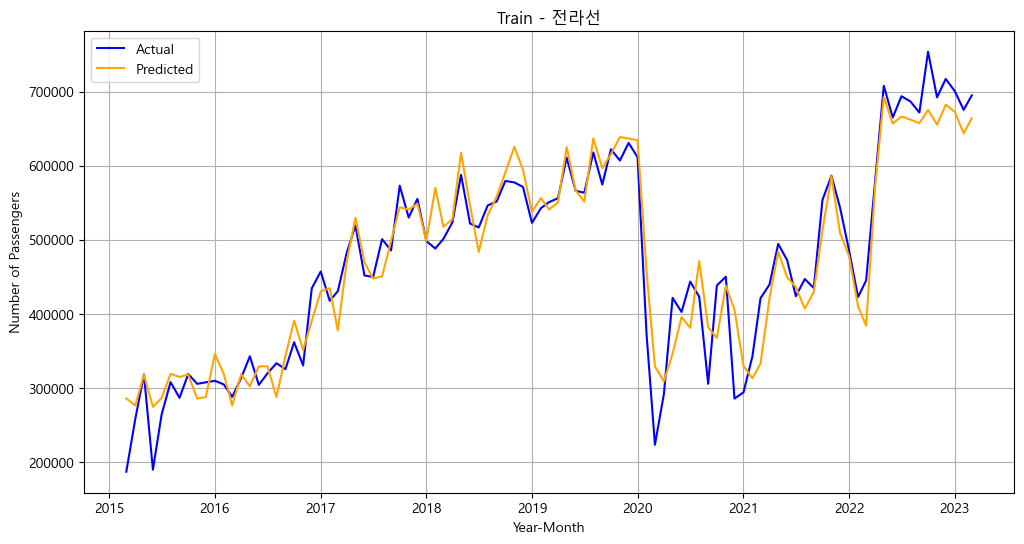

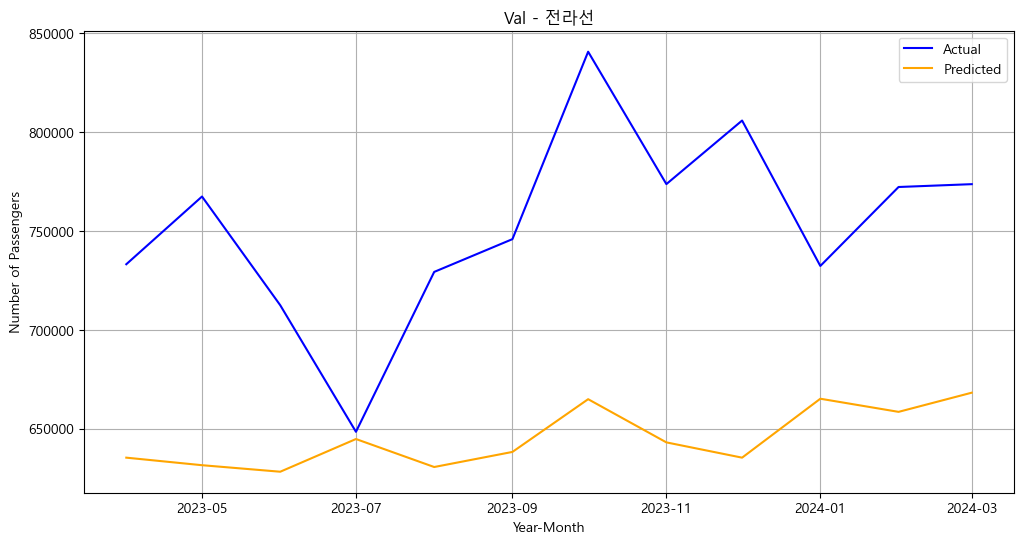



--- 호남선 모델 학습 및 평가 ---

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 7
[LightGBM] [Info] Start training from score 782092.484536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

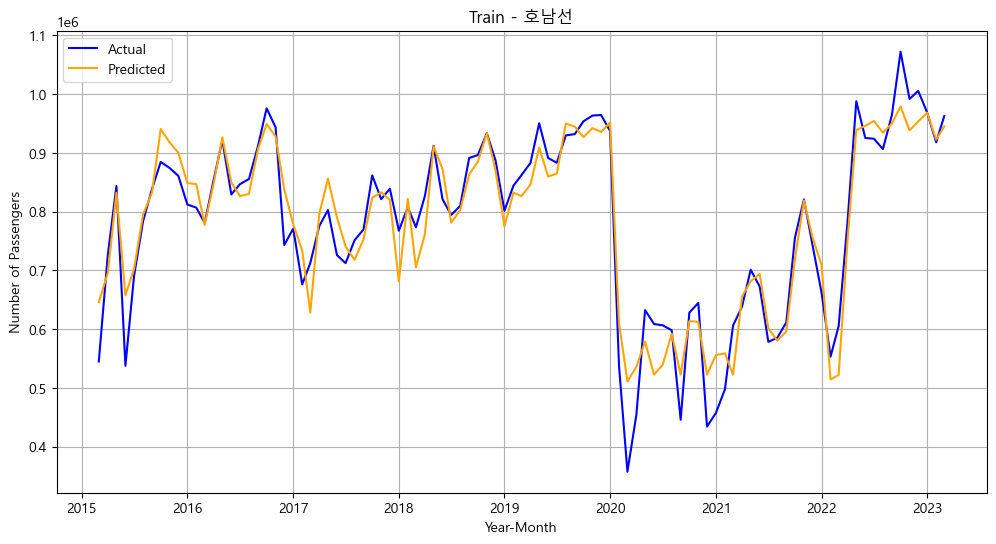

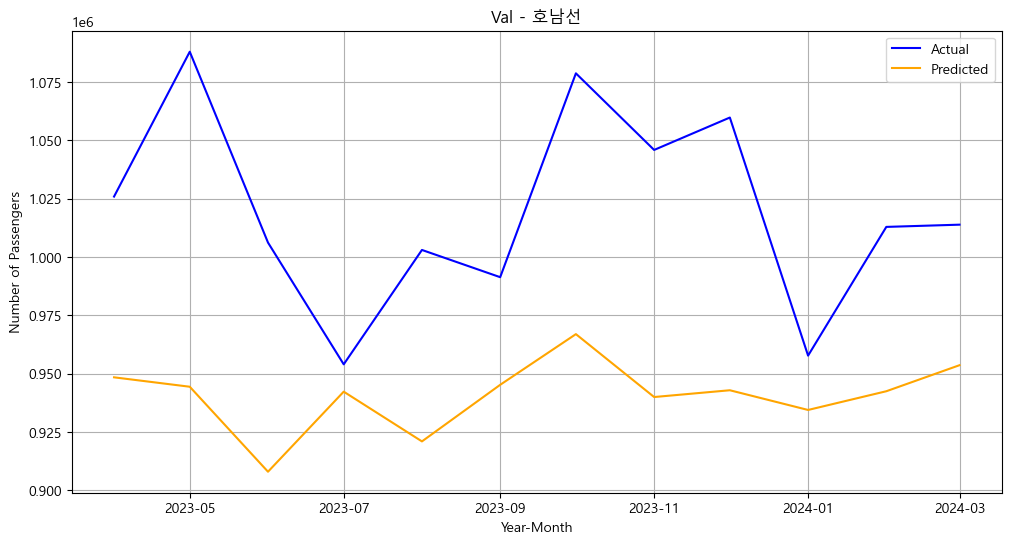

In [15]:
for line_name, data in data_dict.items():
    print(f'\n\n--- {line_name} 모델 학습 및 평가 ---\n')
    
    X_train_scaled = data['X_train_scaled']
    Y_train = data['Y_train']
    X_val_scaled = data['X_val_scaled']
    Y_val = data['Y_val']
    train_data = data['train_data']
    val_data = data['val_data']
    
    best_lgb_model, lgb_results = model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
    print('LightGBM(Train):')
    print(f"R-squared: {lgb_results['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {lgb_results['train_metrics']['mae']:.2f}")
    print(f"MSE: {lgb_results['train_metrics']['mse']:.2f}")
    print(f"MAPE: {lgb_results['train_metrics']['mape']:.2f}%")
    print()
    print('LightGBM(Val):')
    print(f"R-squared: {lgb_results['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {lgb_results['val_metrics']['mae']:.2f}")
    print(f"MSE: {lgb_results['val_metrics']['mse']:.2f}")
    print(f"MAPE: {lgb_results['val_metrics']['mape']:.2f}%")
    
    Y_train_pred_lgb = best_lgb_model.predict(X_train_scaled)
    Y_val_pred_lgb = best_lgb_model.predict(X_val_scaled)
    
    plot_results(train_data, val_data, Y_train, Y_train_pred_lgb, Y_val, Y_val_pred_lgb, line_name)


# 2. DL(LSTM, GRU, RNN)

## 함수

In [30]:
def preprocess_data2(file_path):
    df = pd.read_excel(file_path)
    df['운행년월'] = pd.to_datetime(df['운행년월'], format='%Y-%m')

    lines = ['경부선', '경전선', '동해선', '전라선', '호남선']
    dfs = {}

    for line in lines:
        df_line = df[df['주운행선'] == line].copy()
        df_line['승차인원수_T1'] = df_line['승차인원수'].shift(1)
        df_line['승차인원수_T2'] = df_line['승차인원수'].shift(2)
        df_line.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

        train_data = df_line[(df_line['운행년월'] >= '2015-01-01') & (df_line['운행년월'] <= '2023-03-31')]
        val_data = df_line[(df_line['운행년월'] >= '2023-04-01') & (df_line['운행년월'] <= '2024-03-31')]

        features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '공급대비승차율', '승차인원수_T1', '승차인원수_T2']
        
        X_train = train_data[features].dropna()
        Y_train = train_data.loc[X_train.index, '승차인원수']
        X_val = val_data[features].dropna()
        Y_val = val_data.loc[X_val.index, '승차인원수']

        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
        
        scaler_Y = MinMaxScaler()
        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1))
        Y_val_scaled = scaler_Y.transform(Y_val.values.reshape(-1, 1))
        
        dfs[line] = {
            'X_train_scaled': X_train_scaled,
            'Y_train_scaled': Y_train_scaled,
            'X_val_scaled': X_val_scaled,
            'Y_val_scaled': Y_val_scaled,
            'train_data': train_data,
            'val_data': val_data,
            'scaler_Y': scaler_Y
        }
    
    return dfs

def plot_results2(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred, time_step):
    # Train 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[time_step:], Y_train, label='Actual', color='blue')
    plt.plot(train_data.index[time_step:], Y_train_pred, label='Pred', color='orange')
    plt.title('Train')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(val_data.index[time_step:], Y_val, label='Actual', color='blue')
    plt.plot(val_data.index[time_step:], Y_val_pred, label='Pred', color='orange')
    plt.title('Val')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

## LSTM

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 3, 50)             11800     
                                                                 
 dropout_57 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_58 (Dropout)        (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32051 (125.20 KB)
Trainable params: 32051 (125.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2

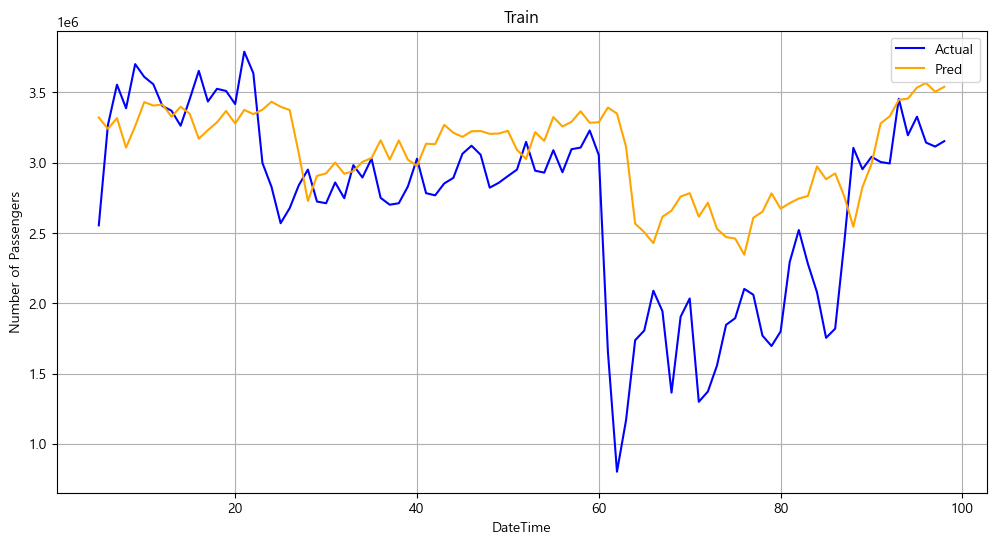

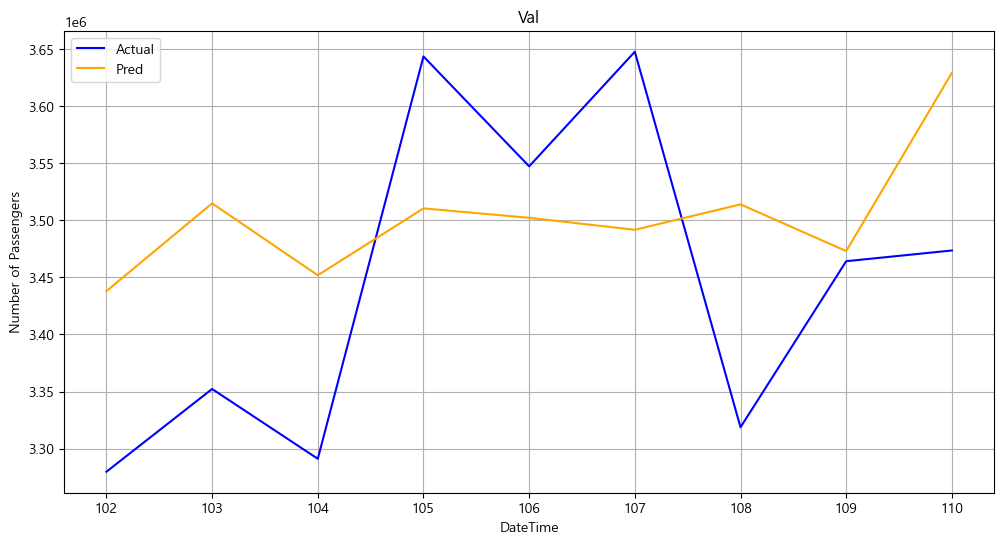

주운행선: 경전선
LSTM(Train):
R-squared: 0.27
MAE: 63869.87
MSE: 7924194898.72
MAPE: 16.97%

LSTM(Val):
R-squared: -9.48
MAE: 82594.74
MSE: 7465635627.26
MAPE: 12.04%



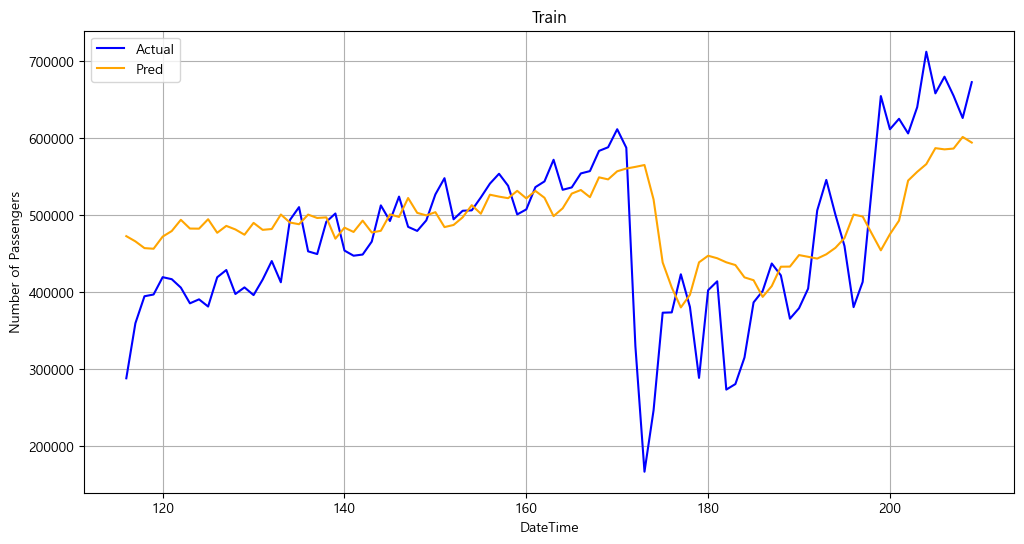

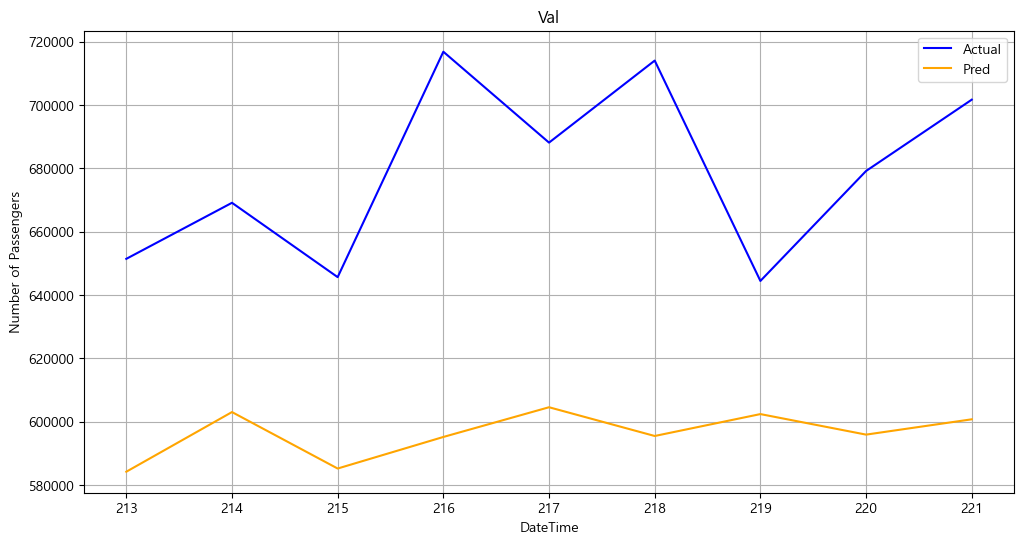

주운행선: 동해선
LSTM(Train):
R-squared: -6.78
MAE: 46048.05
MSE: 2810233435.41
MAPE: 8.52%

LSTM(Val):
R-squared: -0.39
MAE: 17683.99
MSE: 496638280.82
MAPE: 3.03%



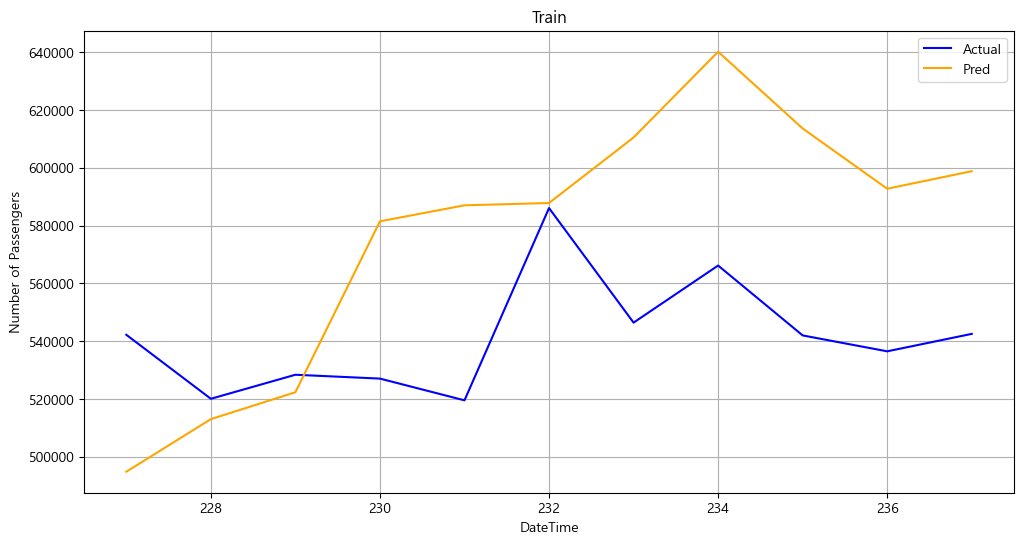

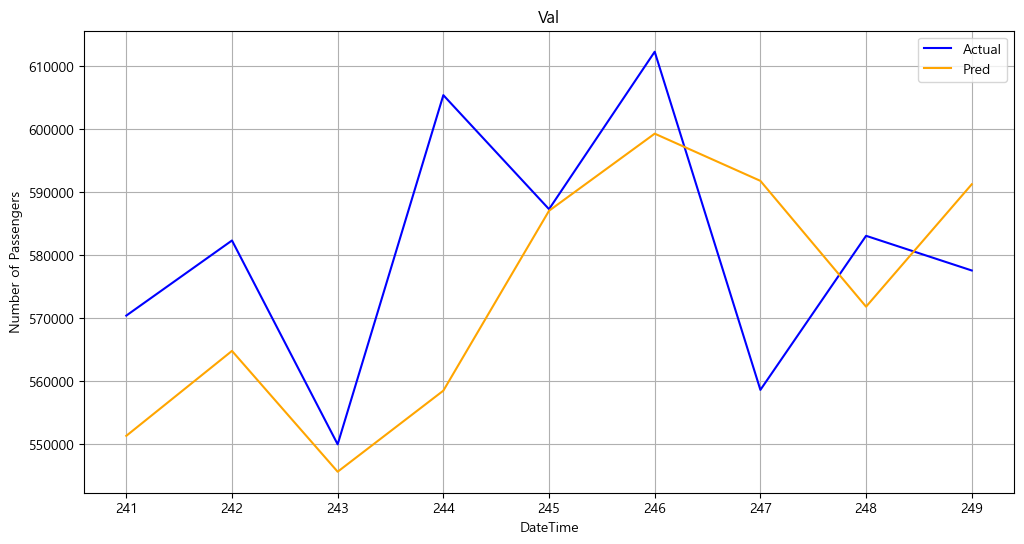

주운행선: 전라선
LSTM(Train):
R-squared: 0.38
MAE: 79658.81
MSE: 10701347265.62
MAPE: 20.93%

LSTM(Val):
R-squared: -7.77
MAE: 142253.54
MSE: 22865651669.08
MAPE: 18.39%



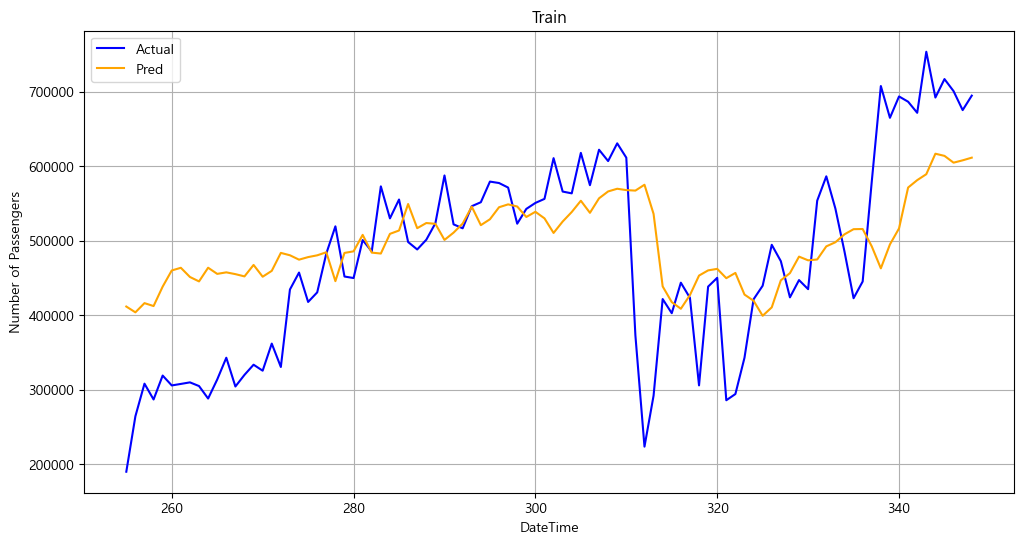

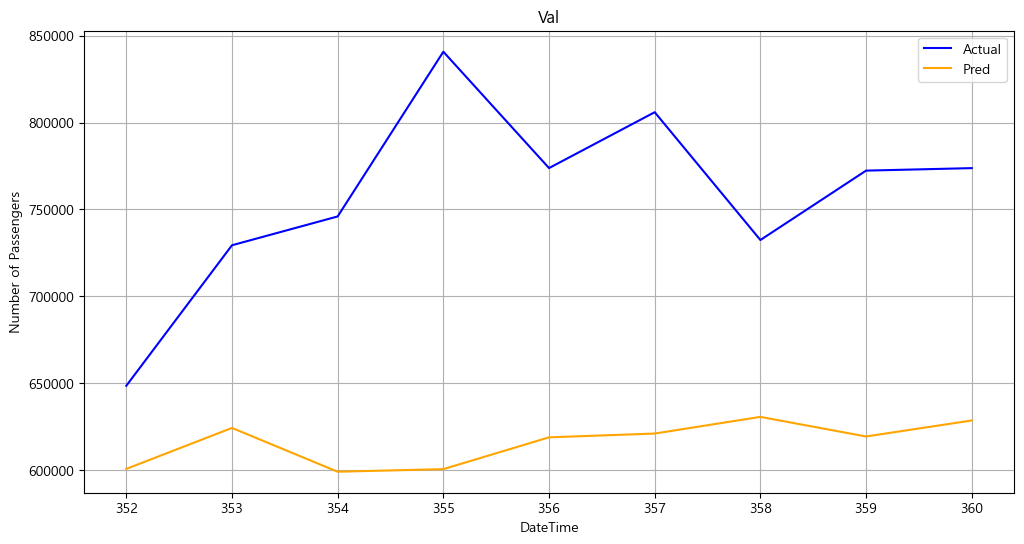

주운행선: 호남선
LSTM(Train):
R-squared: 0.27
MAE: 102406.85
MSE: 16820962123.71
MAPE: 14.56%

LSTM(Val):
R-squared: -10.58
MAE: 132547.97
MSE: 18908591460.35
MAPE: 12.97%



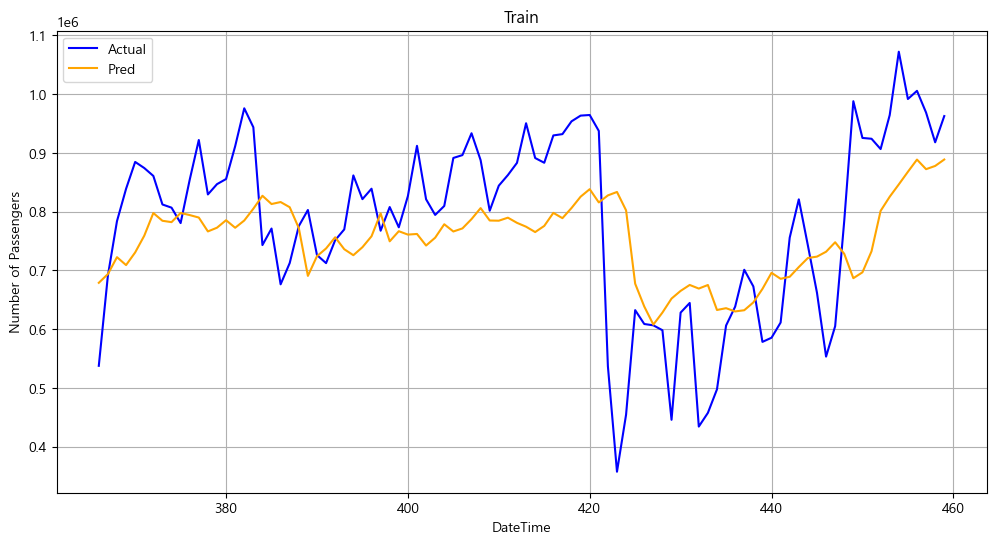

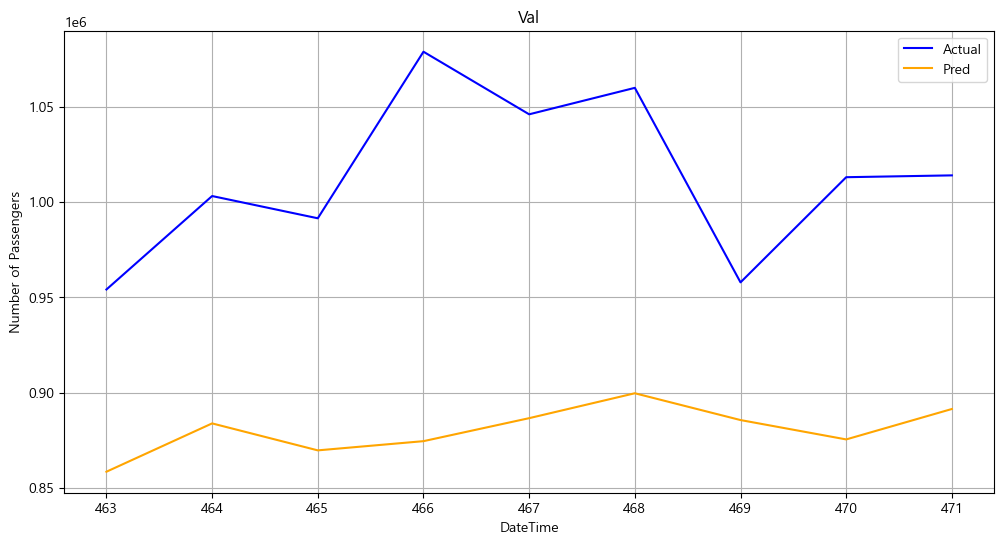

In [31]:
def reshape_for_lstm(X, Y, time_step):
    X_reshaped = []
    Y_reshaped = []
    for i in range(len(X) - time_step):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step])
    return np.array(X_reshaped), np.array(Y_reshaped)

def train_and_evaluate_model(dfs, time_step=3):
    results = {}
    
    for line, data in dfs.items():
        X_train_scaled = data['X_train_scaled'].values
        Y_train_scaled = data['Y_train_scaled']
        X_val_scaled = data['X_val_scaled'].values
        Y_val_scaled = data['Y_val_scaled']
        scaler_Y = data['scaler_Y']
        
        X_train_lstm, Y_train_lstm = reshape_for_lstm(X_train_scaled, Y_train_scaled, time_step)
        X_val_lstm, Y_val_lstm = reshape_for_lstm(X_val_scaled, Y_val_scaled, time_step)

        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
        model.add(Dropout(0.3))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.summary()

        history = model.fit(X_train_lstm, Y_train_lstm, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_lstm, Y_val_lstm), 
                            verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.05)])

        Y_train_pred_lstm = model.predict(X_train_lstm)
        Y_val_pred_lstm = model.predict(X_val_lstm)

        Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_lstm)
        Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_lstm)

        Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
        Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)

        # 지표 계산
        train_r_squared = r2_score(Y_train_actual, Y_train_pred)
        train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
        train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
        train_mape = np.mean(np.abs((Y_train_actual - Y_train_pred) / Y_train_actual)) * 100

        val_r_squared = r2_score(Y_val_actual, Y_val_pred)
        val_mae = mean_absolute_error(Y_val_actual, Y_val_pred)
        val_mse = mean_squared_error(Y_val_actual, Y_val_pred)
        val_mape = np.mean(np.abs((Y_val_actual - Y_val_pred) / Y_val_actual)) * 100

        results[line] = {
            'train_metrics': {
                'r_squared': train_r_squared,
                'mae': train_mae,
                'mse': train_mse,
                'mape': train_mape
            },
            'val_metrics': {
                'r_squared': val_r_squared,
                'mae': val_mae,
                'mse': val_mse,
                'mape': val_mape
            },
            'train_data': data['train_data'],
            'val_data': data['val_data'],
            'Y_train': Y_train_actual.flatten(),
            'Y_train_pred': Y_train_pred.flatten(),
            'Y_val': Y_val_actual.flatten(),
            'Y_val_pred': Y_val_pred.flatten()
        }
        
    return results


# LSTM
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
dfs = preprocess_data2(file_path)
results = train_and_evaluate_model(dfs, time_step=3)

for line, metrics in results.items():
    print(f"주운행선: {line}")
    print('LSTM(Train):')
    print(f"R-squared: {metrics['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['train_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['train_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['train_metrics']['mape']:.2f}%")
    print()
    print('LSTM(Val):')
    print(f"R-squared: {metrics['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['val_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['val_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['val_metrics']['mape']:.2f}%")
    print()

    plot_results2(metrics['train_data'], metrics['val_data'], metrics['Y_train'], metrics['Y_train_pred'], metrics['Y_val'], metrics['Y_val_pred'], time_step)

## GRU

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 3, 50)             9000      
                                                                 
 dropout_67 (Dropout)        (None, 3, 50)             0         
                                                                 
 gru_11 (GRU)                (None, 50)                15300     
                                                                 
 dropout_68 (Dropout)        (None, 50)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 51        
                                                                 
Total params: 24351 (95.12 KB)
Trainable params: 24351 (95.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 -

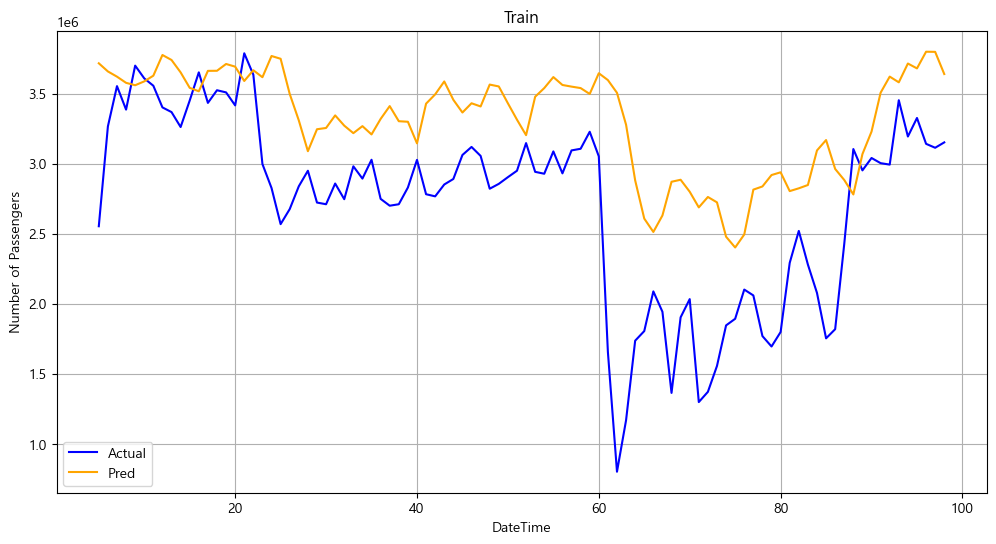

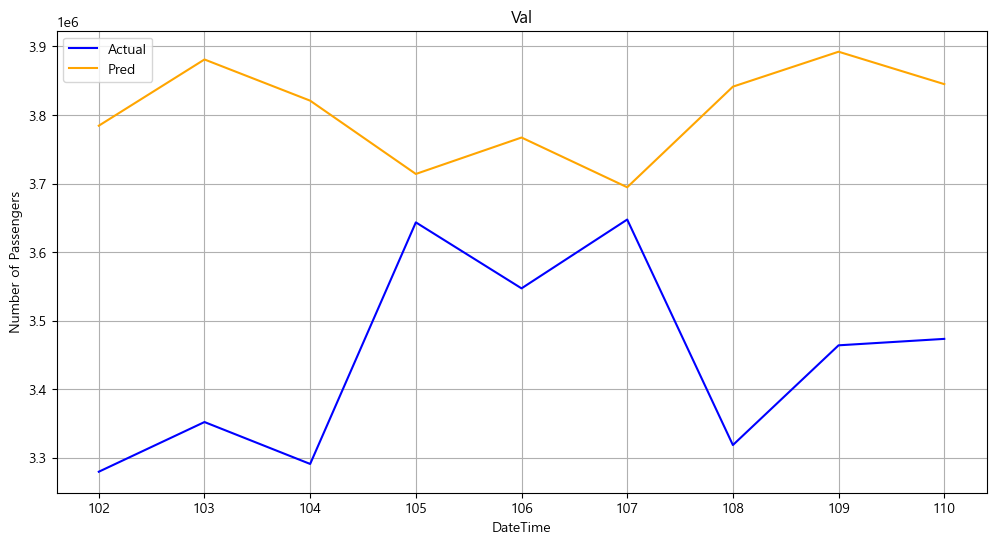

주운행선: 경전선
GRU(Train):
R-squared: 0.16
MAE: 70312.54
MSE: 9132894192.87
MAPE: 19.00%

GRU(Val):
R-squared: -5.98
MAE: 64572.99
MSE: 4971008459.20
MAPE: 9.37%



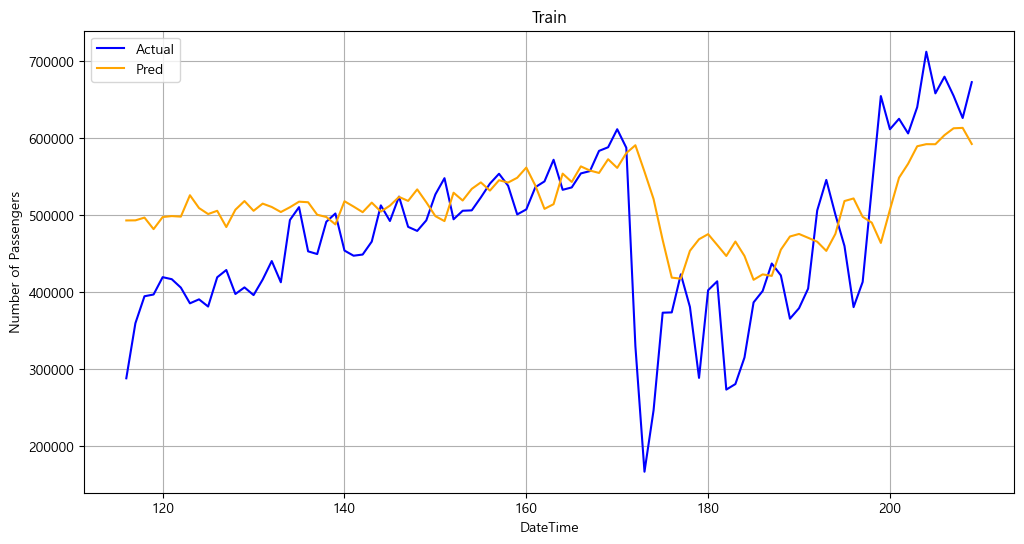

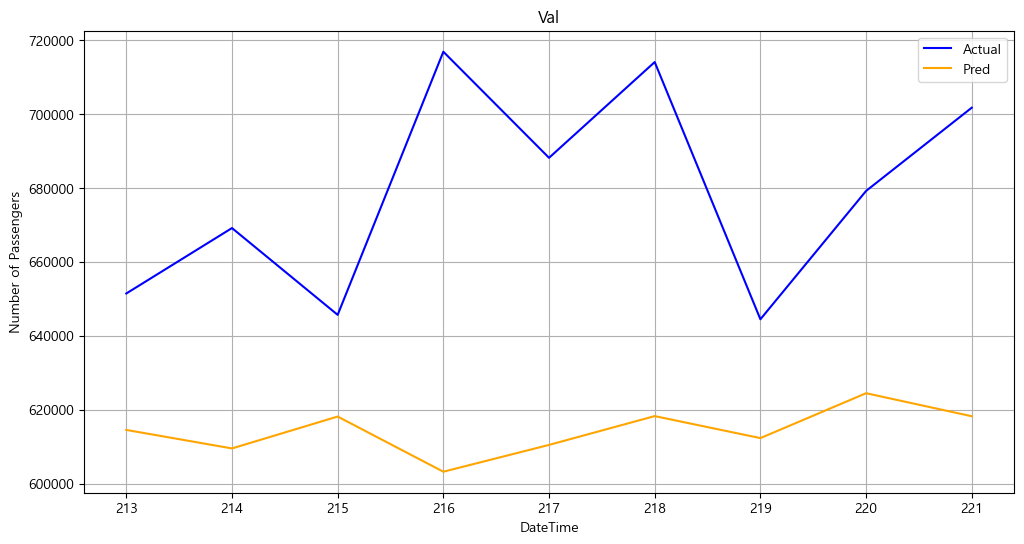

주운행선: 동해선
GRU(Train):
R-squared: -10.75
MAE: 59467.14
MSE: 4243387870.41
MAPE: 11.01%

GRU(Val):
R-squared: -2.05
MAE: 26163.28
MSE: 1085830797.42
MAPE: 4.60%



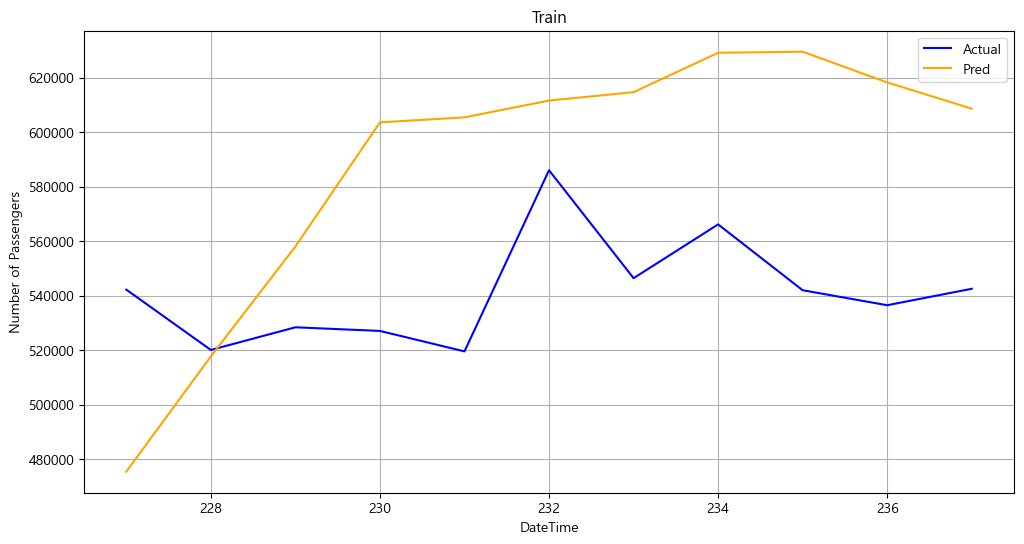

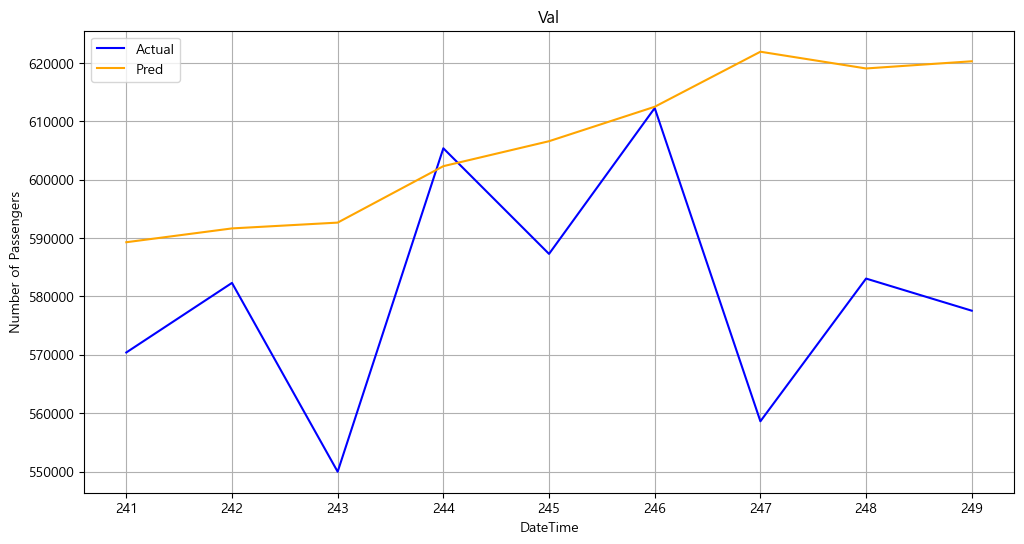

주운행선: 전라선
GRU(Train):
R-squared: 0.42
MAE: 75121.00
MSE: 9924773194.01
MAPE: 19.94%

GRU(Val):
R-squared: -5.62
MAE: 121573.86
MSE: 17268199831.52
MAPE: 15.66%



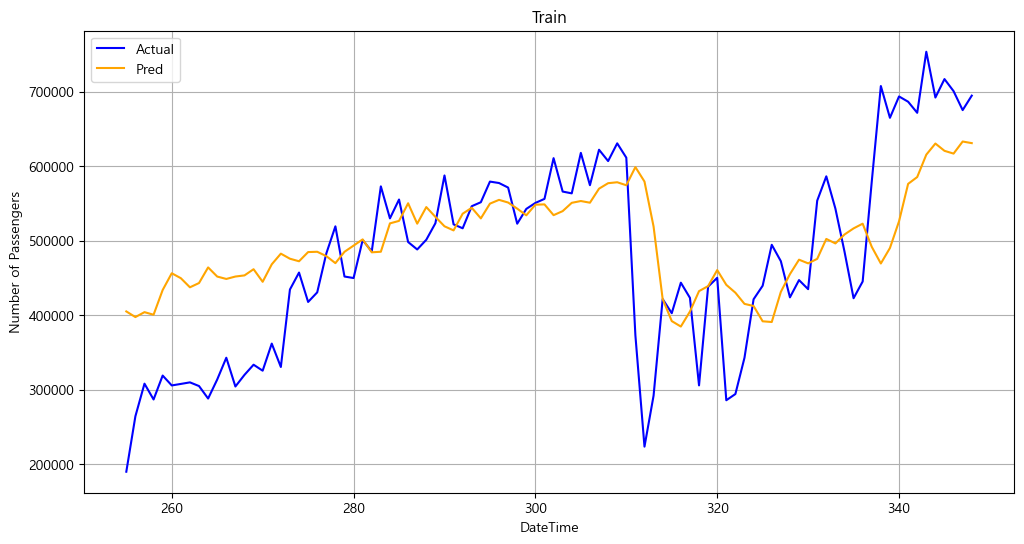

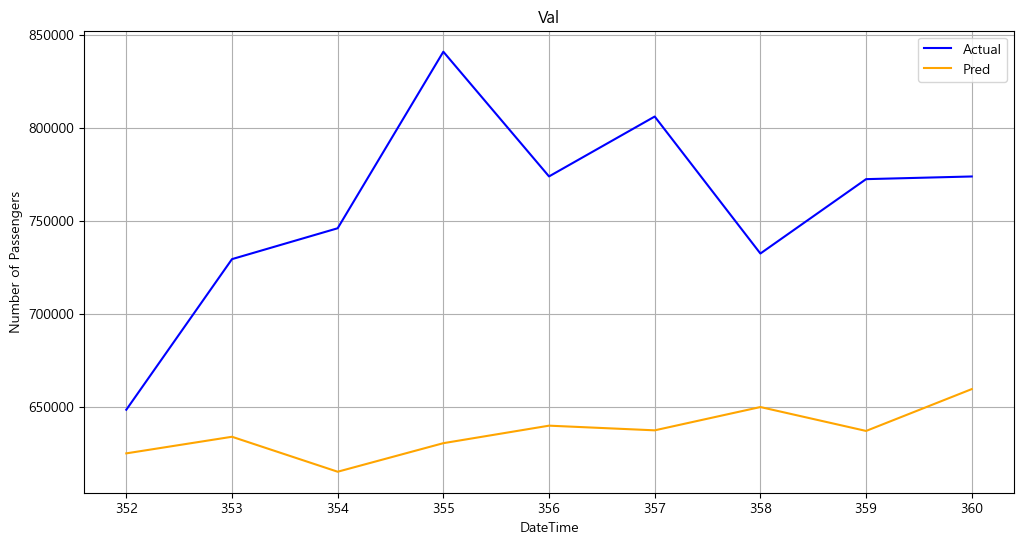

주운행선: 호남선
GRU(Train):
R-squared: 0.23
MAE: 88514.37
MSE: 17921335720.42
MAPE: 14.37%

GRU(Val):
R-squared: 0.27
MAE: 29168.10
MSE: 1186448297.66
MAPE: 2.84%



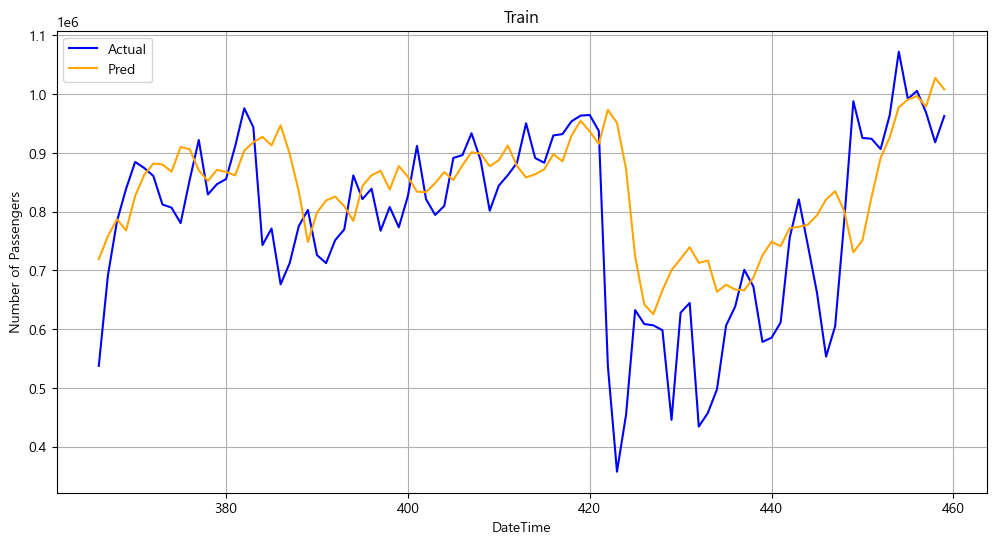

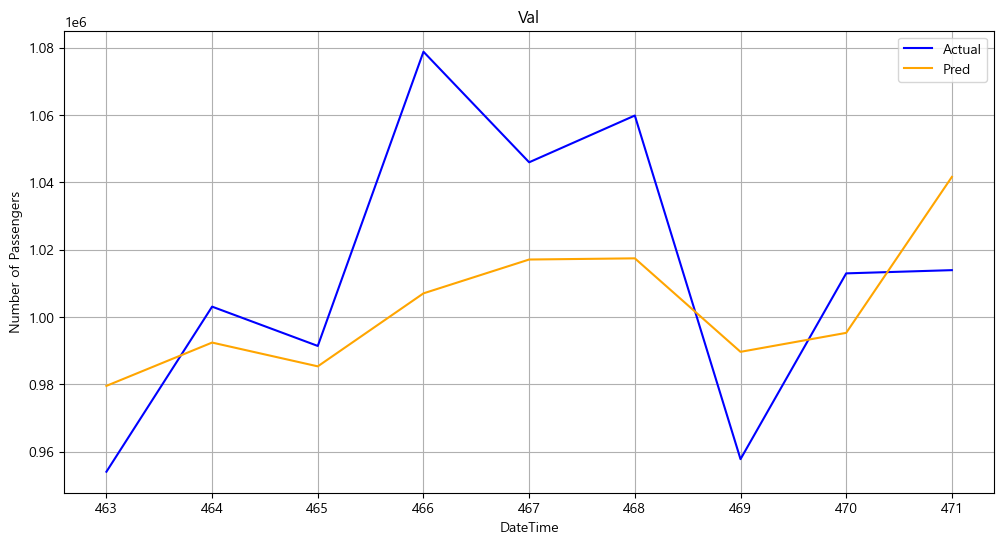

In [32]:
def reshape_for_gru(X, Y, time_step):
    
    X_reshaped = []
    Y_reshaped = []
    for i in range(len(X) - time_step):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step])
    return np.array(X_reshaped), np.array(Y_reshaped)

def train_and_evaluate_gru(dfs, time_step=3):

    results = {}
    
    for line, data in dfs.items():
        X_train_scaled = data['X_train_scaled'].values
        Y_train_scaled = data['Y_train_scaled']
        X_val_scaled = data['X_val_scaled'].values
        Y_val_scaled = data['Y_val_scaled']
        scaler_Y = data['scaler_Y']
        
        X_train_gru, Y_train_gru = reshape_for_gru(X_train_scaled, Y_train_scaled, time_step)
        X_val_gru, Y_val_gru = reshape_for_gru(X_val_scaled, Y_val_scaled, time_step)

        model = Sequential()
        model.add(GRU(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
        model.add(Dropout(0.3))
        model.add(GRU(50, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.summary()

        history = model.fit(X_train_gru, Y_train_gru, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_gru, Y_val_gru), 
                            verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.05)])

        Y_train_pred_gru = model.predict(X_train_gru)
        Y_val_pred_gru = model.predict(X_val_gru)

        Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_gru)
        Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_gru)

        Y_train_actual = scaler_Y.inverse_transform(Y_train_gru)
        Y_val_actual = scaler_Y.inverse_transform(Y_val_gru)

        # 지표 계산
        train_r_squared = r2_score(Y_train_actual, Y_train_pred)
        train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
        train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
        train_mape = np.mean(np.abs((Y_train_actual - Y_train_pred) / Y_train_actual)) * 100

        val_r_squared = r2_score(Y_val_actual, Y_val_pred)
        val_mae = mean_absolute_error(Y_val_actual, Y_val_pred)
        val_mse = mean_squared_error(Y_val_actual, Y_val_pred)
        val_mape = np.mean(np.abs((Y_val_actual - Y_val_pred) / Y_val_actual)) * 100

        results[line] = {
            'train_metrics': {
                'r_squared': train_r_squared,
                'mae': train_mae,
                'mse': train_mse,
                'mape': train_mape
            },
            'val_metrics': {
                'r_squared': val_r_squared,
                'mae': val_mae,
                'mse': val_mse,
                'mape': val_mape
            },
            'train_data': data['train_data'],
            'val_data': data['val_data'],
            'Y_train': Y_train_actual.flatten(),
            'Y_train_pred': Y_train_pred.flatten(),
            'Y_val': Y_val_actual.flatten(),
            'Y_val_pred': Y_val_pred.flatten()
        }
        
    return results

# GRU
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
dfs = preprocess_data(file_path)
results = train_and_evaluate_gru(dfs, time_step=3)

for line, metrics in results.items():
    print(f"주운행선: {line}")
    print('GRU(Train):')
    print(f"R-squared: {metrics['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['train_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['train_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['train_metrics']['mape']:.2f}%")
    print()
    print('GRU(Val):')
    print(f"R-squared: {metrics['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['val_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['val_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['val_metrics']['mape']:.2f}%")
    print()

    plot_results(metrics['train_data'], metrics['val_data'], metrics['Y_train'], metrics['Y_train_pred'], metrics['Y_val'], metrics['Y_val_pred'], time_step)

## RNN

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 3, 50)             2950      
                                                                 
 dropout_77 (Dropout)        (None, 3, 50)             0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_78 (Dropout)        (None, 50)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8051 (31.45 KB)
Trainable params: 8051 (31.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 - 6

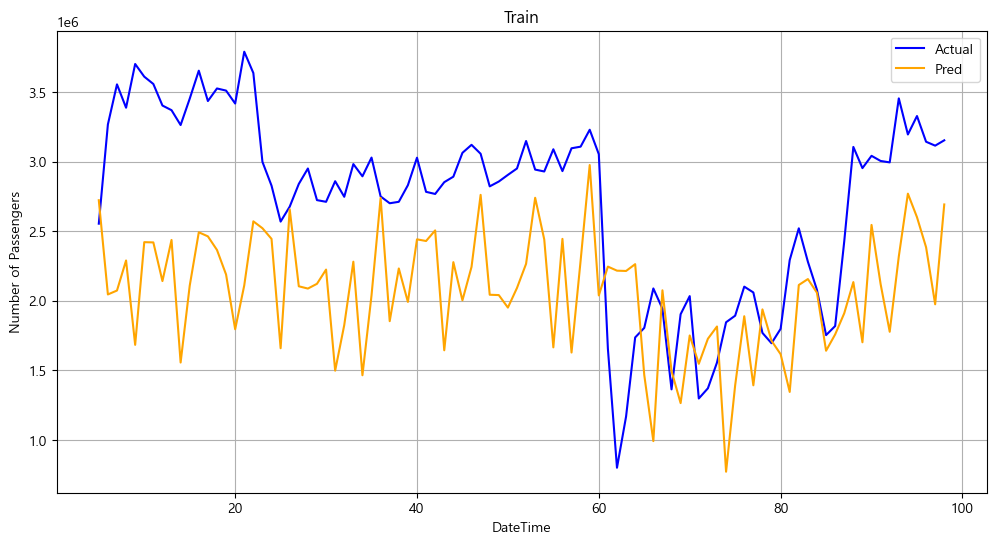

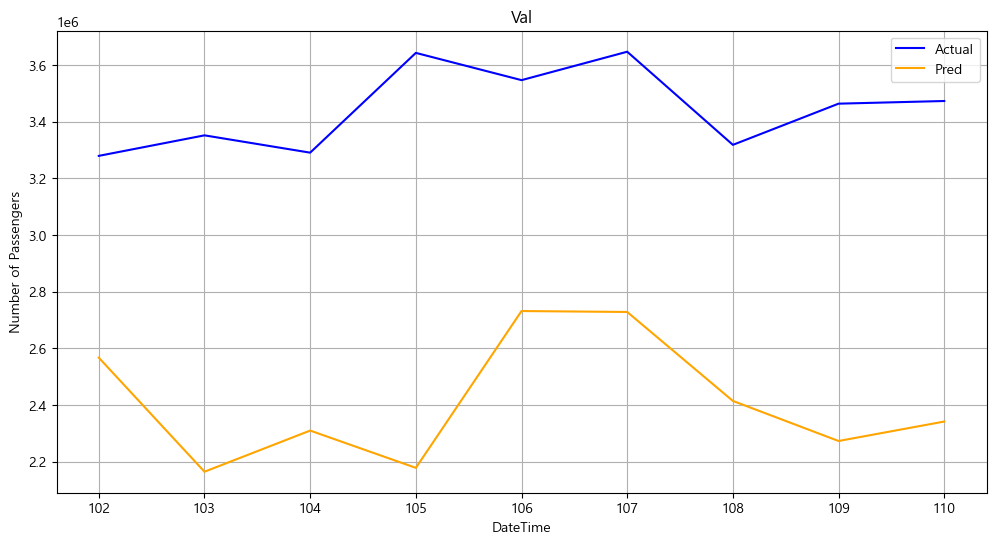

주운행선: 경전선
RNN(Train):
R-squared: -1.48
MAE: 144915.65
MSE: 26839764086.98
MAPE: 31.70%

RNN(Val):
R-squared: -59.92
MAE: 205058.50
MSE: 43411493779.73
MAPE: 30.15%



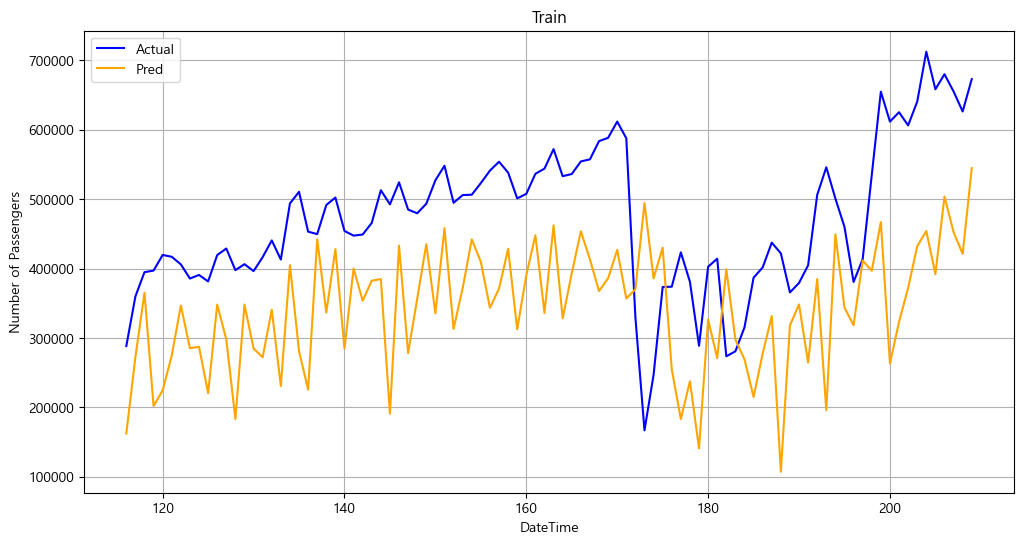

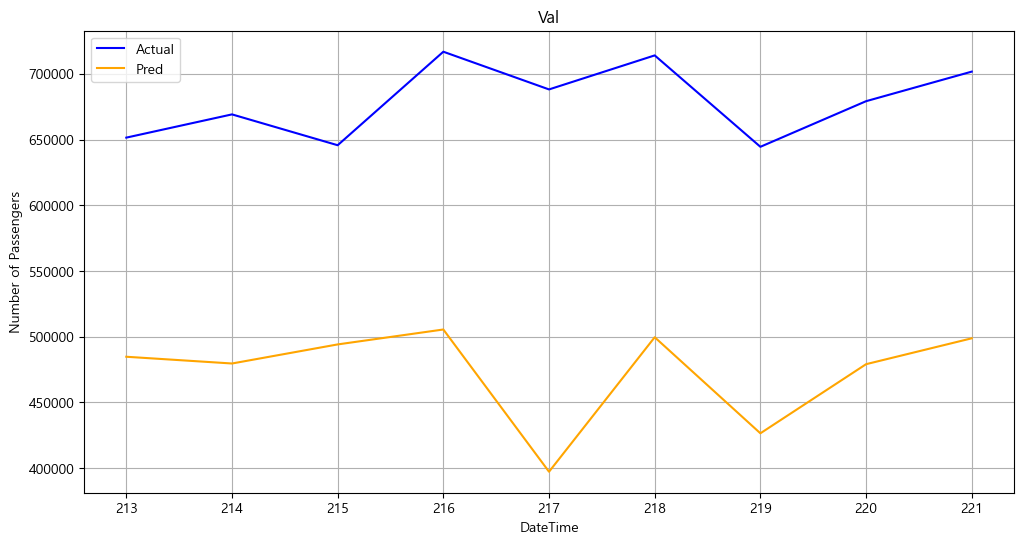

주운행선: 동해선
RNN(Train):
R-squared: -1.94
MAE: 20786.53
MSE: 1060434481.31
MAPE: 3.88%

RNN(Val):
R-squared: -17.24
MAE: 71445.83
MSE: 6492969882.24
MAPE: 12.38%



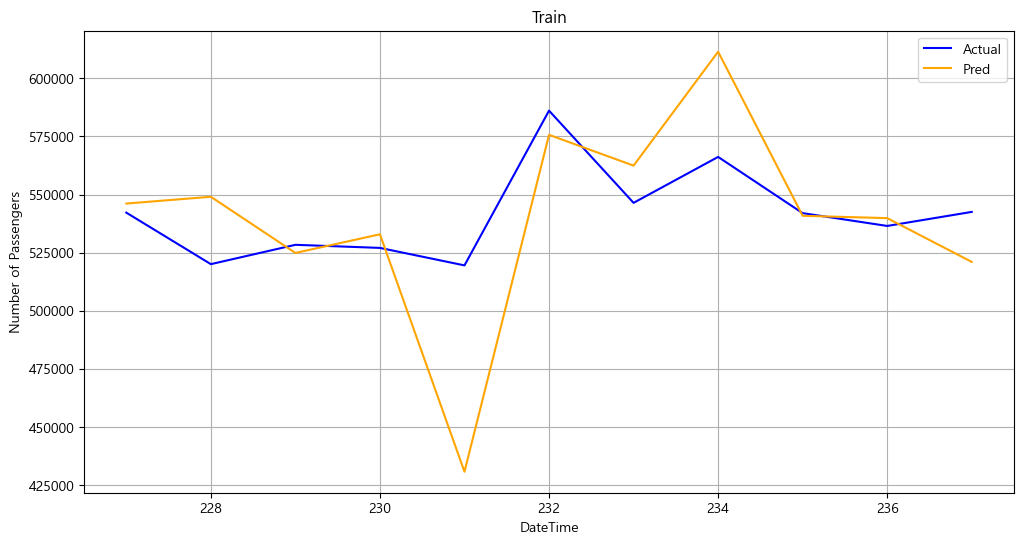

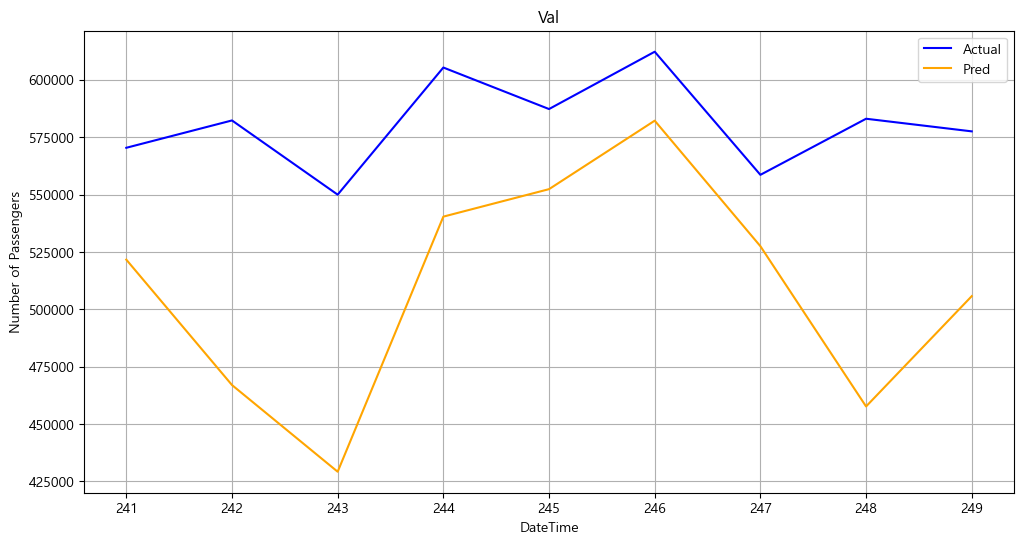

주운행선: 전라선
RNN(Train):
R-squared: -0.34
MAE: 120706.37
MSE: 23079342272.98
MAPE: 25.16%

RNN(Val):
R-squared: -21.03
MAE: 218351.93
MSE: 57442416931.94
MAPE: 28.36%



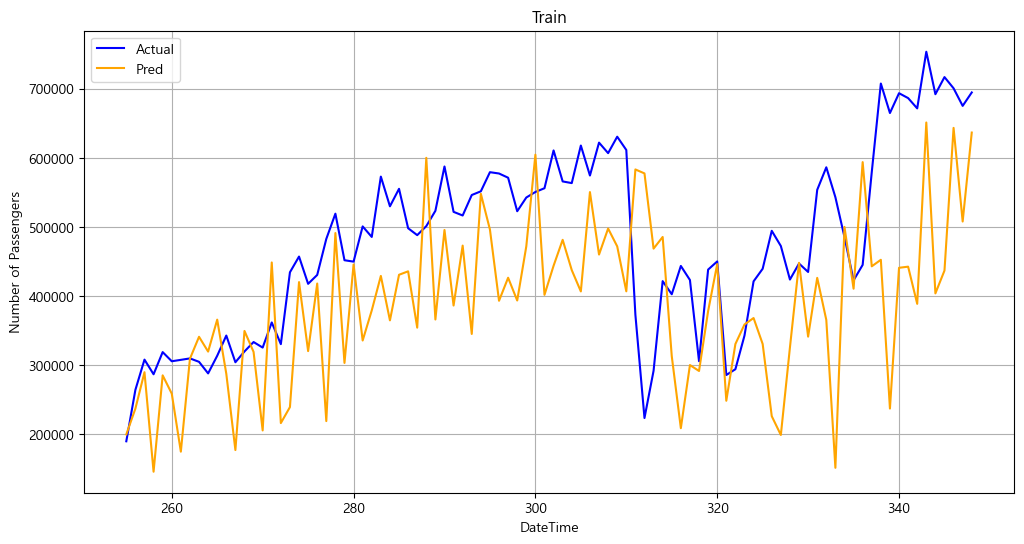

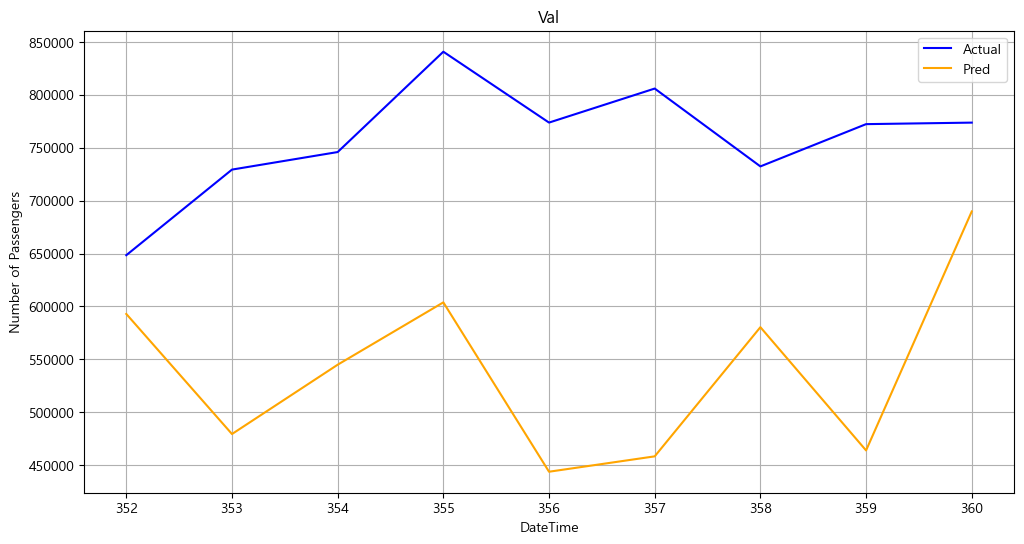

주운행선: 호남선
RNN(Train):
R-squared: -0.44
MAE: 139842.71
MSE: 33398649097.83
MAPE: 20.64%

RNN(Val):
R-squared: -3.13
MAE: 68704.76
MSE: 6749261082.65
MAPE: 6.68%



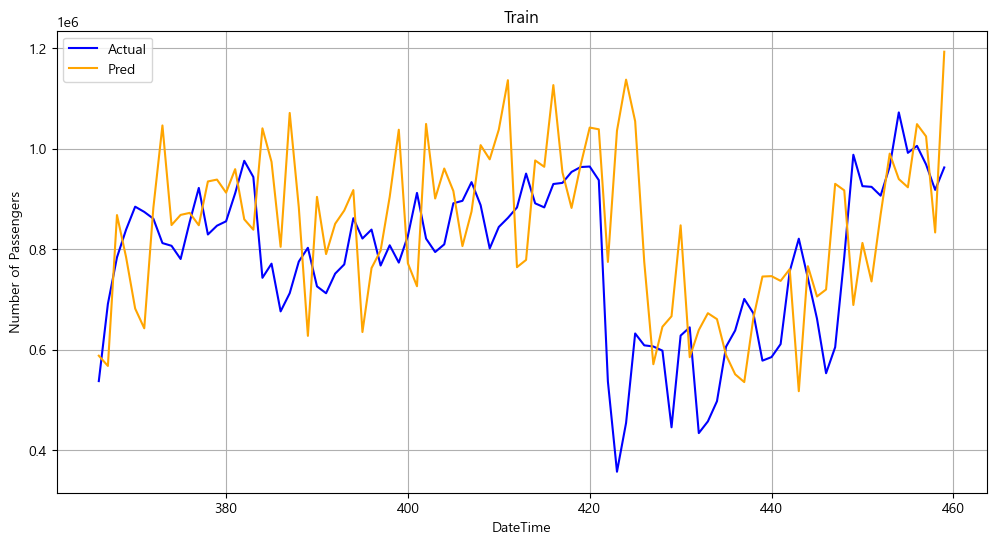

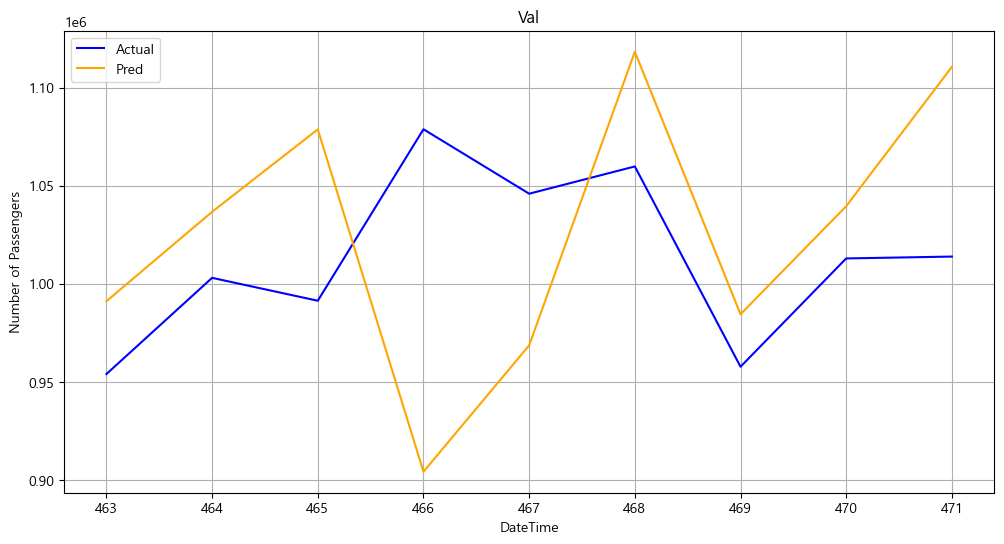

In [33]:
def reshape_for_rnn(X, Y, time_step):

    X_reshaped = []
    Y_reshaped = []
    for i in range(len(X) - time_step):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step])
    return np.array(X_reshaped), np.array(Y_reshaped)

def train_and_evaluate_rnn(dfs, time_step=3):

    results = {}
    
    for line, data in dfs.items():
        X_train_scaled = data['X_train_scaled'].values
        Y_train_scaled = data['Y_train_scaled']
        X_val_scaled = data['X_val_scaled'].values
        Y_val_scaled = data['Y_val_scaled']
        scaler_Y = data['scaler_Y']
        
        X_train_rnn, Y_train_rnn = reshape_for_rnn(X_train_scaled, Y_train_scaled, time_step)
        X_val_rnn, Y_val_rnn = reshape_for_rnn(X_val_scaled, Y_val_scaled, time_step)

        model = Sequential()
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
        model.add(Dropout(0.3))
        model.add(SimpleRNN(50, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.summary()

        history = model.fit(X_train_rnn, Y_train_rnn, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_rnn, Y_val_rnn), 
                            verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.05)])

        Y_train_pred_rnn = model.predict(X_train_rnn)
        Y_val_pred_rnn = model.predict(X_val_rnn)

        Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_rnn)
        Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_rnn)

        Y_train_actual = scaler_Y.inverse_transform(Y_train_rnn)
        Y_val_actual = scaler_Y.inverse_transform(Y_val_rnn)

       
        train_r_squared = r2_score(Y_train_actual, Y_train_pred)
        train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
        train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
        train_mape = np.mean(np.abs((Y_train_actual - Y_train_pred) / Y_train_actual)) * 100

        val_r_squared = r2_score(Y_val_actual, Y_val_pred)
        val_mae = mean_absolute_error(Y_val_actual, Y_val_pred)
        val_mse = mean_squared_error(Y_val_actual, Y_val_pred)
        val_mape = np.mean(np.abs((Y_val_actual - Y_val_pred) / Y_val_actual)) * 100

        results[line] = {
            'train_metrics': {
                'r_squared': train_r_squared,
                'mae': train_mae,
                'mse': train_mse,
                'mape': train_mape
            },
            'val_metrics': {
                'r_squared': val_r_squared,
                'mae': val_mae,
                'mse': val_mse,
                'mape': val_mape
            },
            'train_data': data['train_data'],
            'val_data': data['val_data'],
            'Y_train': Y_train_actual.flatten(),
            'Y_train_pred': Y_train_pred.flatten(),
            'Y_val': Y_val_actual.flatten(),
            'Y_val_pred': Y_val_pred.flatten()
        }
        
    return results

# RNN
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
dfs = preprocess_data(file_path)
results = train_and_evaluate_rnn(dfs, time_step=3)

for line, metrics in results.items():
    print(f"주운행선: {line}")
    print('RNN(Train):')
    print(f"R-squared: {metrics['train_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['train_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['train_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['train_metrics']['mape']:.2f}%")
    print()
    print('RNN(Val):')
    print(f"R-squared: {metrics['val_metrics']['r_squared']:.2f}")
    print(f"MAE: {metrics['val_metrics']['mae']:.2f}")
    print(f"MSE: {metrics['val_metrics']['mse']:.2f}")
    print(f"MAPE: {metrics['val_metrics']['mape']:.2f}%")
    print()

    plot_results(metrics['train_data'], metrics['val_data'], metrics['Y_train'], metrics['Y_train_pred'], metrics['Y_val'], metrics['Y_val_pred'], time_step)

# 3. 모델 평가

In [52]:
# 머신러닝 모델 학습 및 평가
all_ml_results = {'RandomForest': [], 'XGBoost': [], 'LightGBM': []}

for line_name, data in data_dict.items():
    print(f'\n\n--- {line_name} 머신러닝 모델 학습 및 평가 ---\n')
    
    X_train_scaled = data['X_train_scaled']
    Y_train = data['Y_train']
    X_val_scaled = data['X_val_scaled']
    Y_val = data['Y_val']
    
    # Random Forest
    best_rf_model, rf_results = model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
    rf_result = {
        'Line': line_name,
        'Model': 'RandomForest',
        'MAE': rf_results['val_metrics']['mae'],
        'MSE': rf_results['val_metrics']['mse'],
        'MAPE': rf_results['val_metrics']['mape']
    }
    all_ml_results['RandomForest'].append(rf_result)
    
    # XGBoost
    best_xgb_model, xgb_results = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
    xgb_result = {
        'Line': line_name,
        'Model': 'XGBoost',
        'MAE': xgb_results['val_metrics']['mae'],
        'MSE': xgb_results['val_metrics']['mse'],
        'MAPE': xgb_results['val_metrics']['mape']
    }
    all_ml_results['XGBoost'].append(xgb_result)
    
    # LightGBM
    best_lgb_model, lgb_results = model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
    lgb_result = {
        'Line': line_name,
        'Model': 'LightGBM',
        'MAE': lgb_results['val_metrics']['mae'],
        'MSE': lgb_results['val_metrics']['mse'],
        'MAPE': lgb_results['val_metrics']['mape']
    }
    all_ml_results['LightGBM'].append(lgb_result)



--- 경부선 머신러닝 모델 학습 및 평가 ---

100%|██████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59trial/s, best loss: 115617.45833333333]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 7
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [54]:
def create_summary_table(results):
    data = []
    
    # LSTM 결과 추가
    for line, metrics in results['LSTM'].items():
        row = {
            'Line': line,
            'Model': 'LSTM',
            'MAE': metrics['val_metrics']['mae'],
            'MSE': metrics['val_metrics']['mse'],
            'MAPE': metrics['val_metrics']['mape']
        }
        data.append(row)
    
    # GRU 결과 추가
    for line, metrics in results['GRU'].items():
        row = {
            'Line': line,
            'Model': 'GRU',
            'MAE': metrics['val_metrics']['mae'],
            'MSE': metrics['val_metrics']['mse'],
            'MAPE': metrics['val_metrics']['mape']
        }
        data.append(row)
    
    # RNN 결과 추가
    for line, metrics in results['RNN'].items():
        row = {
            'Line': line,
            'Model': 'RNN',
            'MAE': metrics['val_metrics']['mae'],
            'MSE': metrics['val_metrics']['mse'],
            'MAPE': metrics['val_metrics']['mape']
        }
        data.append(row)

    # 머신러닝 결과 추가
    for model_type, results_list in all_ml_results.items():
        for result in results_list:
            data.append({
                'Line': result['Line'],
                'Model': model_type,
                'MAE': result['MAE'],
                'MSE': result['MSE'],
                'MAPE': result['MAPE']
            })
    
    summary_df = pd.DataFrame(data)
    return summary_df

In [55]:
# 딥러닝 모델 결과를 통합
all_results = {
    'LSTM': lstm_results,
    'GRU': gru_results,
    'RNN': rnn_results
}

In [59]:
# 요약 테이블 생성 및 출력
summary_df = create_summary_table(all_results)

# MAPE 기준으로 정렬
summary_df_sorted = summary_df.sort_values(by='MAPE')
summary_df_sorted

Line         Model           MAE           MSE       MAPE
2   동해선          LSTM  1.697624e+04  5.116555e+08   2.931366
24  호남선       XGBoost  3.408141e+04  1.987318e+09   3.280885
7   동해선           GRU  1.957863e+04  5.293923e+08   3.344521
20  경부선       XGBoost  1.156175e+05  1.721600e+10   3.384842
21  경전선       XGBoost  2.438931e+04  8.106959e+08   3.508264
25  경부선      LightGBM  1.416548e+05  2.768356e+10   4.139137
0   경부선          LSTM  1.428597e+05  2.415162e+10   4.200606
22  동해선       XGBoost  2.554265e+04  9.710030e+08   4.309396
19  호남선  RandomForest  4.731343e+04  3.368491e+09   4.526075
17  동해선  RandomForest  3.373233e+04  1.496849e+09   5.709680
16  경전선  RandomForest  4.380621e+04  2.431345e+09   6.314309
15  경부선  RandomForest  2.459437e+05  7.909249e+10   7.049466
29  호남선      LightGBM  7.898365e+04  7.648949e+09   7.618446
5   경부선           GRU  2.982496e+05  1.057276e+11   8.805792
23  전라선       XGBoost  6.853959e+04  5.635697e+09   8.900260
9   호남선           GRU  9.790596e+04  1.122290e+10   9.834397
4   호남선          LSTM  1.007948e+05  1.140251e+10   9.836116
26  경전선      LightGBM  7.062022e+04  5.765688e+09  10.248641
18  전라선  RandomForest  8.169172e+04  8.048295e+09  10.595214
13  전라선           RNN  8.251999e+04  9.514639e+09  10.748154
12  동해선           RNN  7.106569e+04  8.244559e+09  12.077813
1   경전선          LSTM  8.686588e+04  8.291310e+09  12.665917
27  동해선      LightGBM  7.827681e+04  6.494473e+09  13.384271
28  전라선      LightGBM  1.076225e+05  1.351172e+10  13.991778
8   전라선           GRU  1.104330e+05  1.470409e+10  14.186307
3   전라선          LSTM  1.252976e+05  1.857546e+10  16.129391
6   경전선           GRU  1.172123e+05  1.412482e+10  17.220654
11  경전선           RNN  1.875178e+05  4.110040e+10  27.573846
14  호남선           RNN  3.329816e+05  1.181678e+11  32.816361
10  경부선           RNN  1.838151e+06  3.557188e+12  53.778117

In [61]:
# 주운행선별 가장 좋은 모델 찾기
best_models = summary_df_sorted.groupby('Line').first().reset_index()

# 결과 출력
best_models

Line    Model            MAE           MSE      MAPE
0  경부선  XGBoost  115617.458333  1.721600e+10  3.384842
1  경전선  XGBoost   24389.312500  8.106959e+08  3.508264
2  동해선     LSTM   16976.236111  5.116555e+08  2.931366
3  전라선  XGBoost   68539.593750  5.635697e+09  8.900260
4  호남선  XGBoost   34081.411458  1.987318e+09  3.280885

In [7]:
# XGBoost 모델 저장
best_xgb_model.save_model('xgboost_model.xgb')

# 4. Test(2024년4월~2025년12월)

In [61]:
# 주말/주중 변수 생성 함수
def create_weekend_weekday(df):
    df['요일'] = df['운행일자'].dt.weekday
    weekday_list = ['월', '화', '수', '목', '금', '토', '일']
    df['요일'] = df['요일'].apply(lambda x: weekday_list[x])
    df['주말여부'] = df['요일'].apply(lambda x: '주말' if x in ['금', '토', '일'] else '주중')
    return df

# 공휴일 변수 생성 함수
kr_holidays = holidays.KR()
def is_holiday(date):
    return date in kr_holidays

def create_holiday_variable(df):
    df['공휴일여부'] = df['운행일자'].apply(lambda x: '공휴일' if is_holiday(x) else '평일')
    return df

# 명절 변수 생성 함수
seollal_dates = pd.to_datetime(['2024-02-10', '2025-01-29'])
chuseok_dates = pd.to_datetime(['2024-09-17', '2025-10-06'])
seollal_holidays = seollal_dates.union(seollal_dates - timedelta(days=1)).union(seollal_dates + timedelta(days=1))
chuseok_holidays = chuseok_dates.union(chuseok_dates - timedelta(days=1)).union(chuseok_dates + timedelta(days=1))

def create_festival_variable(df):
    df['명절여부'] = df['운행일자'].apply(lambda x: '명절' if x in seollal_holidays or x in chuseok_holidays else '비명절')
    return df

# 2024년 4월부터 2025년 12월까지의 일자별 데이터 생성
all_dates = pd.date_range(start='2024-04-01', end='2025-12-31', freq='D')
date_info = pd.DataFrame(all_dates, columns=['운행일자'])

# 주말, 공휴일, 명절 여부 계산
date_info = create_weekend_weekday(date_info)
date_info = create_holiday_variable(date_info)
date_info = create_festival_variable(date_info)
date_info['운행년월'] = date_info['운행일자'].dt.to_period('M')

# 월별 변수 집계
monthly_info = date_info.groupby('운행년월').agg({
    '주말여부': lambda x: (x == '주말').sum(),
    '공휴일여부': lambda x: (x == '공휴일').sum(),
    '명절여부': lambda x: (x == '명절').sum(),
    '요일': 'count'  # 총 일수 계산
}).rename(columns={'주말여부': '주말수', '공휴일여부': '공휴일수', '명절여부': '명절수', '요일': '총일수'}).reset_index()

# 평일수 계산
monthly_info['평일수'] = monthly_info['총일수'] - monthly_info['주말수'] - monthly_info['공휴일수']
monthly_info = monthly_info[['운행년월', '주말수', '공휴일수', '명절수', '평일수']]

test_df = monthly_info.copy()

test_df


운행년월  주말수  공휴일수  명절수  평일수
0   2024-04   12     1    0   17
1   2024-05   13     3    0   15
2   2024-06   14     1    0   15
3   2024-07   12     0    0   19
4   2024-08   14     1    0   16
5   2024-09   13     3    3   14
6   2024-10   12     2    0   17
7   2024-11   14     0    0   16
8   2024-12   13     1    0   17
9   2025-01   13     4    3   14
10  2025-02   12     0    0   16
11  2025-03   14     2    0   15
12  2025-04   12     0    0   18
13  2025-05   14     2    0   15
14  2025-06   13     1    0   16
15  2025-07   12     0    0   19
16  2025-08   15     1    0   15
17  2025-09   12     0    0   18
18  2025-10   13     6    3   12
19  2025-11   14     0    0   16
20  2025-12   12     1    0   18

In [62]:
vkospi_values = [
    18.489048, 16.337619, 16.667368, 16.561765, 35.151499, 
    20.149452, 18.161680, 17.175196, 17.196362, 17.219427, 
    17.238888, 17.258978, 17.279095, 17.296976, 17.316032, 
    17.331850, 17.345844, 17.357851, 17.369129, 17.379562, 
    17.389141
]

# VKOSPI 값 채우기
test_df['VKOSPI'] = vkospi_values

test_df

운행년월  주말수  공휴일수  명절수  평일수     VKOSPI
0   2024-04   12     1    0   17  18.489048
1   2024-05   13     3    0   15  16.337619
2   2024-06   14     1    0   15  16.667368
3   2024-07   12     0    0   19  16.561765
4   2024-08   14     1    0   16  35.151499
5   2024-09   13     3    3   14  20.149452
6   2024-10   12     2    0   17  18.161680
7   2024-11   14     0    0   16  17.175196
8   2024-12   13     1    0   17  17.196362
9   2025-01   13     4    3   14  17.219427
10  2025-02   12     0    0   16  17.238888
11  2025-03   14     2    0   15  17.258978
12  2025-04   12     0    0   18  17.279095
13  2025-05   14     2    0   15  17.296976
14  2025-06   13     1    0   16  17.316032
15  2025-07   12     0    0   19  17.331850
16  2025-08   15     1    0   15  17.345844
17  2025-09   12     0    0   18  17.357851
18  2025-10   13     6    3   12  17.369129
19  2025-11   14     0    0   16  17.379562
20  2025-12   12     1    0   18  17.389141

In [63]:
# datetime 변환
df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')

# 추출
df_filtered2 = df_gbline[(df_gbline['운행년월'] >= '2022-07-01') & (df_gbline['운행년월'] <= '2024-03-31')]
df_filtered2 = df_filtered2[['운행년월','공급대비승차율']]
df_filtered2

운행년월   공급대비승차율
90  2022-07-01  1.240006
91  2022-08-01  1.255400
92  2022-09-01  1.280305
93  2022-10-01  1.368498
94  2022-11-01  1.367333
95  2022-12-01  1.330322
96  2023-01-01  1.274727
97  2023-02-01  1.380978
98  2023-03-01  1.310766
99  2023-04-01  1.359010
100 2023-05-01  1.387361
101 2023-06-01  1.346886
102 2023-07-01  1.314978
103 2023-08-01  1.342812
104 2023-09-01  1.222263
105 2023-10-01  1.233520
106 2023-11-01  1.283311
107 2023-12-01  1.290221
108 2024-01-01  1.303080
109 2024-02-01  1.383754
110 2024-03-01  1.341282

In [64]:
# 날짜 형식 변환
df_filtered2['운행년월'] = pd.to_datetime(df_filtered2['운행년월'])

# 날짜, 시작일
start_date = pd.Timestamp('2024-04-01')

# 날짜 업데이트
df_filtered2['운행년월'] = pd.date_range(start=start_date, periods=len(df_filtered2), freq='MS')

# 형식 변경
df_filtered2['운행년월'] = df_filtered2['운행년월'].dt.strftime('%Y-%m')

# 출력
df_filtered2

운행년월   공급대비승차율
90   2024-04  1.240006
91   2024-05  1.255400
92   2024-06  1.280305
93   2024-07  1.368498
94   2024-08  1.367333
95   2024-09  1.330322
96   2024-10  1.274727
97   2024-11  1.380978
98   2024-12  1.310766
99   2025-01  1.359010
100  2025-02  1.387361
101  2025-03  1.346886
102  2025-04  1.314978
103  2025-05  1.342812
104  2025-06  1.222263
105  2025-07  1.233520
106  2025-08  1.283311
107  2025-09  1.290221
108  2025-10  1.303080
109  2025-11  1.383754
110  2025-12  1.341282

In [65]:
# 문자열로 변환
df_filtered2['운행년월'] = df_filtered2['운행년월'].astype(str)
test_df['운행년월'] = test_df['운행년월'].astype(str)

# 병합
test_df = pd.merge(df_filtered2, test_df, on='운행년월', how='right')

test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI
0   2024-04  1.240006   12     1    0   17  18.489048
1   2024-05  1.255400   13     3    0   15  16.337619
2   2024-06  1.280305   14     1    0   15  16.667368
3   2024-07  1.368498   12     0    0   19  16.561765
4   2024-08  1.367333   14     1    0   16  35.151499
5   2024-09  1.330322   13     3    3   14  20.149452
6   2024-10  1.274727   12     2    0   17  18.161680
7   2024-11  1.380978   14     0    0   16  17.175196
8   2024-12  1.310766   13     1    0   17  17.196362
9   2025-01  1.359010   13     4    3   14  17.219427
10  2025-02  1.387361   12     0    0   16  17.238888
11  2025-03  1.346886   14     2    0   15  17.258978
12  2025-04  1.314978   12     0    0   18  17.279095
13  2025-05  1.342812   14     2    0   15  17.296976
14  2025-06  1.222263   13     1    0   16  17.316032
15  2025-07  1.233520   12     0    0   19  17.331850
16  2025-08  1.283311   15     1    0   15  17.345844
17  2025-09  1.290221   12     0    0   18  17.357851
18  2025-10  1.303080   13     6    3   12  17.369129
19  2025-11  1.383754   14     0    0   16  17.379562
20  2025-12  1.341282   12     1    0   18  17.389141

In [66]:
# datetime으로 변환
df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')

# 추출
df_filtered = df_gbline[(df_gbline['운행년월'] >= '2024-02-01') & (df_gbline['운행년월'] <= '2024-03-31')]
df_filtered = df_filtered[['운행년월','승차인원수_T1', '승차인원수_T2']]

df_filtered

운행년월   승차인원수_T1   승차인원수_T2
109 2024-02-01  3318669.0  3647548.0
110 2024-03-01  3464111.0  3318669.0

In [67]:
# 값 추출
t1_value = df_filtered[df_filtered['운행년월'] == '2024-03-01']['승차인원수_T1'].values[0]
t2_value = df_filtered[df_filtered['운행년월'] == '2024-03-01']['승차인원수_T2'].values[0]


In [68]:
# 승차인원수_T1과 승차인원수_T2 값 추가
test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수_T1']  = t1_value
test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수_T2'] = t2_value

test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2
0   2024-04  1.240006   12     1    0   17  18.489048  3464111.0  3318669.0
1   2024-05  1.255400   13     3    0   15  16.337619        NaN        NaN
2   2024-06  1.280305   14     1    0   15  16.667368        NaN        NaN
3   2024-07  1.368498   12     0    0   19  16.561765        NaN        NaN
4   2024-08  1.367333   14     1    0   16  35.151499        NaN        NaN
5   2024-09  1.330322   13     3    3   14  20.149452        NaN        NaN
6   2024-10  1.274727   12     2    0   17  18.161680        NaN        NaN
7   2024-11  1.380978   14     0    0   16  17.175196        NaN        NaN
8   2024-12  1.310766   13     1    0   17  17.196362        NaN        NaN
9   2025-01  1.359010   13     4    3   14  17.219427        NaN        NaN
10  2025-02  1.387361   12     0    0   16  17.238888        NaN        NaN
11  2025-03  1.346886   14     2    0   15  17.258978        NaN        NaN
12  2025-04  1.314978   12     0    0   18  17.279095        NaN        NaN
13  2025-05  1.342812   14     2    0   15  17.296976        NaN        NaN
14  2025-06  1.222263   13     1    0   16  17.316032        NaN        NaN
15  2025-07  1.233520   12     0    0   19  17.331850        NaN        NaN
16  2025-08  1.283311   15     1    0   15  17.345844        NaN        NaN
17  2025-09  1.290221   12     0    0   18  17.357851        NaN        NaN
18  2025-10  1.303080   13     6    3   12  17.369129        NaN        NaN
19  2025-11  1.383754   14     0    0   16  17.379562        NaN        NaN
20  2025-12  1.341282   12     1    0   18  17.389141        NaN        NaN

In [69]:
# XGBoost 모델 로드
model = xgb.Booster()
model.load_model('xgboost_model.xgb')

In [70]:
test_data = test_df[test_df['운행년월'] == '2024-04']
test_data2 = test_data.drop(columns=['운행년월'])
test_df2 = pd.DataFrame(test_data2)

# XGBoost DMatrix 객체 생성
dtest = xgb.DMatrix(test_df2)

# 예측 수행
predictions = model.predict(dtest)

# 결과 출력
print(f"2024-04 승차인원수 예측: {predictions[0]}")

2024-04 승차인원수 예측: 3137388.0


In [71]:
predicted_value = predictions[0]

test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수'] = predicted_value

test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2  \
0   2024-04  1.240006   12     1    0   17  18.489048  3464111.0  3318669.0   
1   2024-05  1.255400   13     3    0   15  16.337619        NaN        NaN   
2   2024-06  1.280305   14     1    0   15  16.667368        NaN        NaN   
3   2024-07  1.368498   12     0    0   19  16.561765        NaN        NaN   
4   2024-08  1.367333   14     1    0   16  35.151499        NaN        NaN   
5   2024-09  1.330322   13     3    3   14  20.149452        NaN        NaN   
6   2024-10  1.274727   12     2    0   17  18.161680        NaN        NaN   
7   2024-11  1.380978   14     0    0   16  17.175196        NaN        NaN   
8   2024-12  1.310766   13     1    0   17  17.196362        NaN        NaN   
9   2025-01  1.359010   13     4    3   14  17.219427        NaN        NaN   
10  2025-02  1.387361   12     0    0   16  17.238888        NaN        NaN   
11  2025-03  1.346886   14     2    0   15  17.258978        NaN        NaN   
12  2025-04  1.314978   12     0    0   18  17.279095        NaN        NaN   
13  2025-05  1.342812   14     2    0   15  17.296976        NaN        NaN   
14  2025-06  1.222263   13     1    0   16  17.316032        NaN        NaN   
15  2025-07  1.233520   12     0    0   19  17.331850        NaN        NaN   
16  2025-08  1.283311   15     1    0   15  17.345844        NaN        NaN   
17  2025-09  1.290221   12     0    0   18  17.357851        NaN        NaN   
18  2025-10  1.303080   13     6    3   12  17.369129        NaN        NaN   
19  2025-11  1.383754   14     0    0   16  17.379562        NaN        NaN   
20  2025-12  1.341282   12     1    0   18  17.389141        NaN        NaN   

        승차인원수  
0   3137388.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  
10        NaN  
11        NaN  
12        NaN  
13        NaN  
14        NaN  
15        NaN  
16        NaN  
17        NaN  
18        NaN  
19        NaN  
20        NaN

In [73]:
test_df['운행년월'] = pd.to_datetime(test_df['운행년월'], format='%Y-%m')
df_filtered = test_df[test_df['운행년월'].dt.strftime('%Y-%m') == '2024-04'][['운행년월', '승차인원수_T1', '승차인원수_T2','승차인원수']]

In [74]:
# 값 추출
t1_value = df_filtered[df_filtered['운행년월'] == '2024-04']['승차인원수'].values[0]
t2_value = df_filtered[df_filtered['운행년월'] == '2024-04']['승차인원수_T1'].values[0]

In [75]:
# 승차인원수_T1과 승차인원수_T2 값 추가
test_df.loc[test_df['운행년월'] == '2024-05', '승차인원수_T1']  = t1_value
test_df.loc[test_df['운행년월'] == '2024-05', '승차인원수_T2'] = t2_value

In [76]:
test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2  \
0  2024-04-01  1.240006   12     1    0   17  18.489048  3464111.0  3318669.0   
1  2024-05-01  1.255400   13     3    0   15  16.337619  3137388.0  3464111.0   
2  2024-06-01  1.280305   14     1    0   15  16.667368        NaN        NaN   
3  2024-07-01  1.368498   12     0    0   19  16.561765        NaN        NaN   
4  2024-08-01  1.367333   14     1    0   16  35.151499        NaN        NaN   
5  2024-09-01  1.330322   13     3    3   14  20.149452        NaN        NaN   
6  2024-10-01  1.274727   12     2    0   17  18.161680        NaN        NaN   
7  2024-11-01  1.380978   14     0    0   16  17.175196        NaN        NaN   
8  2024-12-01  1.310766   13     1    0   17  17.196362        NaN        NaN   
9  2025-01-01  1.359010   13     4    3   14  17.219427        NaN        NaN   
10 2025-02-01  1.387361   12     0    0   16  17.238888        NaN        NaN   
11 2025-03-01  1.346886   14     2    0   15  17.258978        NaN        NaN   
12 2025-04-01  1.314978   12     0    0   18  17.279095        NaN        NaN   
13 2025-05-01  1.342812   14     2    0   15  17.296976        NaN        NaN   
14 2025-06-01  1.222263   13     1    0   16  17.316032        NaN        NaN   
15 2025-07-01  1.233520   12     0    0   19  17.331850        NaN        NaN   
16 2025-08-01  1.283311   15     1    0   15  17.345844        NaN        NaN   
17 2025-09-01  1.290221   12     0    0   18  17.357851        NaN        NaN   
18 2025-10-01  1.303080   13     6    3   12  17.369129        NaN        NaN   
19 2025-11-01  1.383754   14     0    0   16  17.379562        NaN        NaN   
20 2025-12-01  1.341282   12     1    0   18  17.389141        NaN        NaN   

        승차인원수  
0   3137388.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  
10        NaN  
11        NaN  
12        NaN  
13        NaN  
14        NaN  
15        NaN  
16        NaN  
17        NaN  
18        NaN  
19        NaN  
20        NaN

In [77]:
test_data = test_df[test_df['운행년월'] == '2024-05']
test_data2 = test_data.drop(columns=['운행년월','승차인원수'])
test_df2 = pd.DataFrame(test_data2)

# XGBoost DMatrix 객체 생성
dtest = xgb.DMatrix(test_df2)

# 예측 수행
predictions = model.predict(dtest)

# 결과 출력
print(f"2024-05 승차인원수 예측: {predictions[0]}")

2024-05 승차인원수 예측: 3137388.0


In [78]:
predicted_value = predictions[0]

test_df.loc[test_df['운행년월'] == '2024-05', '승차인원수'] = predicted_value

test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2  \
0  2024-04-01  1.240006   12     1    0   17  18.489048  3464111.0  3318669.0   
1  2024-05-01  1.255400   13     3    0   15  16.337619  3137388.0  3464111.0   
2  2024-06-01  1.280305   14     1    0   15  16.667368        NaN        NaN   
3  2024-07-01  1.368498   12     0    0   19  16.561765        NaN        NaN   
4  2024-08-01  1.367333   14     1    0   16  35.151499        NaN        NaN   
5  2024-09-01  1.330322   13     3    3   14  20.149452        NaN        NaN   
6  2024-10-01  1.274727   12     2    0   17  18.161680        NaN        NaN   
7  2024-11-01  1.380978   14     0    0   16  17.175196        NaN        NaN   
8  2024-12-01  1.310766   13     1    0   17  17.196362        NaN        NaN   
9  2025-01-01  1.359010   13     4    3   14  17.219427        NaN        NaN   
10 2025-02-01  1.387361   12     0    0   16  17.238888        NaN        NaN   
11 2025-03-01  1.346886   14     2    0   15  17.258978        NaN        NaN   
12 2025-04-01  1.314978   12     0    0   18  17.279095        NaN        NaN   
13 2025-05-01  1.342812   14     2    0   15  17.296976        NaN        NaN   
14 2025-06-01  1.222263   13     1    0   16  17.316032        NaN        NaN   
15 2025-07-01  1.233520   12     0    0   19  17.331850        NaN        NaN   
16 2025-08-01  1.283311   15     1    0   15  17.345844        NaN        NaN   
17 2025-09-01  1.290221   12     0    0   18  17.357851        NaN        NaN   
18 2025-10-01  1.303080   13     6    3   12  17.369129        NaN        NaN   
19 2025-11-01  1.383754   14     0    0   16  17.379562        NaN        NaN   
20 2025-12-01  1.341282   12     1    0   18  17.389141        NaN        NaN   

        승차인원수  
0   3137388.0  
1   3137388.0  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  
10        NaN  
11        NaN  
12        NaN  
13        NaN  
14        NaN  
15        NaN  
16        NaN  
17        NaN  
18        NaN  
19        NaN  
20        NaN

In [79]:
# 반복할 월의 범위 설정
start_date = pd.to_datetime('2024-05')
end_date = pd.to_datetime('2025-11')

current_date = start_date

while current_date <= end_date:
    # 문자열 포맷으로 현재 월 생성
    current_month_str = current_date.strftime('%Y-%m')
    
    # 현재 월 데이터 필터링
    df_filtered = test_df[test_df['운행년월'].dt.strftime('%Y-%m') == current_month_str][['운행년월', '승차인원수_T1', '승차인원수_T2', '승차인원수']]
    
    if df_filtered.empty:
        print(f"{current_month_str} 데이터가 없습니다.")
        current_date = (current_date + pd.DateOffset(months=1))
        continue
    
    # 값 추출
    t1_value = df_filtered[df_filtered['운행년월'] == current_month_str]['승차인원수'].values[0]
    t2_value = df_filtered[df_filtered['운행년월'] == current_month_str]['승차인원수_T1'].values[0]

    # 다음 월 데이터 업데이트
    next_month_str = (current_date + pd.DateOffset(months=1)).strftime('%Y-%m')
    test_df.loc[test_df['운행년월'].dt.strftime('%Y-%m') == next_month_str, '승차인원수_T1'] = t1_value
    test_df.loc[test_df['운행년월'].dt.strftime('%Y-%m') == next_month_str, '승차인원수_T2'] = t2_value
    
    # 다음 월 데이터 준비
    test_data = test_df[test_df['운행년월'].dt.strftime('%Y-%m') == next_month_str]
    test_data2 = test_data.drop(columns=['운행년월', '승차인원수'])
    
    # XGBoost DMatrix 객체 생성
    dtest = xgb.DMatrix(test_data2)

    # 예측 수행
    predictions = model.predict(dtest)

    # 결과 출력 및 업데이트
    predicted_value = predictions[0]
    print(f"{next_month_str} 승차인원수 예측: {predicted_value}")
    test_df.loc[test_df['운행년월'].dt.strftime('%Y-%m') == next_month_str, '승차인원수'] = predicted_value

    # 다음 월로 이동
    current_date = (current_date + pd.DateOffset(months=1))

2024-06 승차인원수 예측: 3137388.0
2024-07 승차인원수 예측: 3135101.5
2024-08 승차인원수 예측: 3137388.0
2024-09 승차인원수 예측: 3149923.75
2024-10 승차인원수 예측: 3137388.0
2024-11 승차인원수 예측: 3135101.5
2024-12 승차인원수 예측: 3137388.0
2025-01 승차인원수 예측: 3149923.75
2025-02 승차인원수 예측: 3135101.5
2025-03 승차인원수 예측: 3137388.0
2025-04 승차인원수 예측: 3135101.5
2025-05 승차인원수 예측: 3137388.0
2025-06 승차인원수 예측: 3137388.0
2025-07 승차인원수 예측: 3135101.5
2025-08 승차인원수 예측: 3137388.0
2025-09 승차인원수 예측: 3135101.5
2025-10 승차인원수 예측: 3149923.75
2025-11 승차인원수 예측: 3135101.5
2025-12 승차인원수 예측: 3137388.0


In [80]:
test_df

운행년월   공급대비승차율  주말수  공휴일수  명절수  평일수     VKOSPI    승차인원수_T1  \
0  2024-04-01  1.240006   12     1    0   17  18.489048  3464111.00   
1  2024-05-01  1.255400   13     3    0   15  16.337619  3137388.00   
2  2024-06-01  1.280305   14     1    0   15  16.667368  3137388.00   
3  2024-07-01  1.368498   12     0    0   19  16.561765  3137388.00   
4  2024-08-01  1.367333   14     1    0   16  35.151499  3135101.50   
5  2024-09-01  1.330322   13     3    3   14  20.149452  3137388.00   
6  2024-10-01  1.274727   12     2    0   17  18.161680  3149923.75   
7  2024-11-01  1.380978   14     0    0   16  17.175196  3137388.00   
8  2024-12-01  1.310766   13     1    0   17  17.196362  3135101.50   
9  2025-01-01  1.359010   13     4    3   14  17.219427  3137388.00   
10 2025-02-01  1.387361   12     0    0   16  17.238888  3149923.75   
11 2025-03-01  1.346886   14     2    0   15  17.258978  3135101.50   
12 2025-04-01  1.314978   12     0    0   18  17.279095  3137388.00   
13 2025-05-01  1.342812   14     2    0   15  17.296976  3135101.50   
14 2025-06-01  1.222263   13     1    0   16  17.316032  3137388.00   
15 2025-07-01  1.233520   12     0    0   19  17.331850  3137388.00   
16 2025-08-01  1.283311   15     1    0   15  17.345844  3135101.50   
17 2025-09-01  1.290221   12     0    0   18  17.357851  3137388.00   
18 2025-10-01  1.303080   13     6    3   12  17.369129  3135101.50   
19 2025-11-01  1.383754   14     0    0   16  17.379562  3149923.75   
20 2025-12-01  1.341282   12     1    0   18  17.389141  3135101.50   

      승차인원수_T2       승차인원수  
0   3318669.00  3137388.00  
1   3464111.00  3137388.00  
2   3137388.00  3137388.00  
3   3137388.00  3135101.50  
4   3137388.00  3137388.00  
5   3135101.50  3149923.75  
6   3137388.00  3137388.00  
7   3149923.75  3135101.50  
8   3137388.00  3137388.00  
9   3135101.50  3149923.75  
10  3137388.00  3135101.50  
11  3149923.75  3137388.00  
12  3135101.50  3135101.50  
13  3137388.00  3137388.00  
14  3135101.50  3137388.00  
15  3137388.00  3135101.50  
16  3137388.00  3137388.00  
17  3135101.50  3135101.50  
18  3137388.00  3149923.75  
19  3135101.50  3135101.50  
20  3149923.75  3137388.00

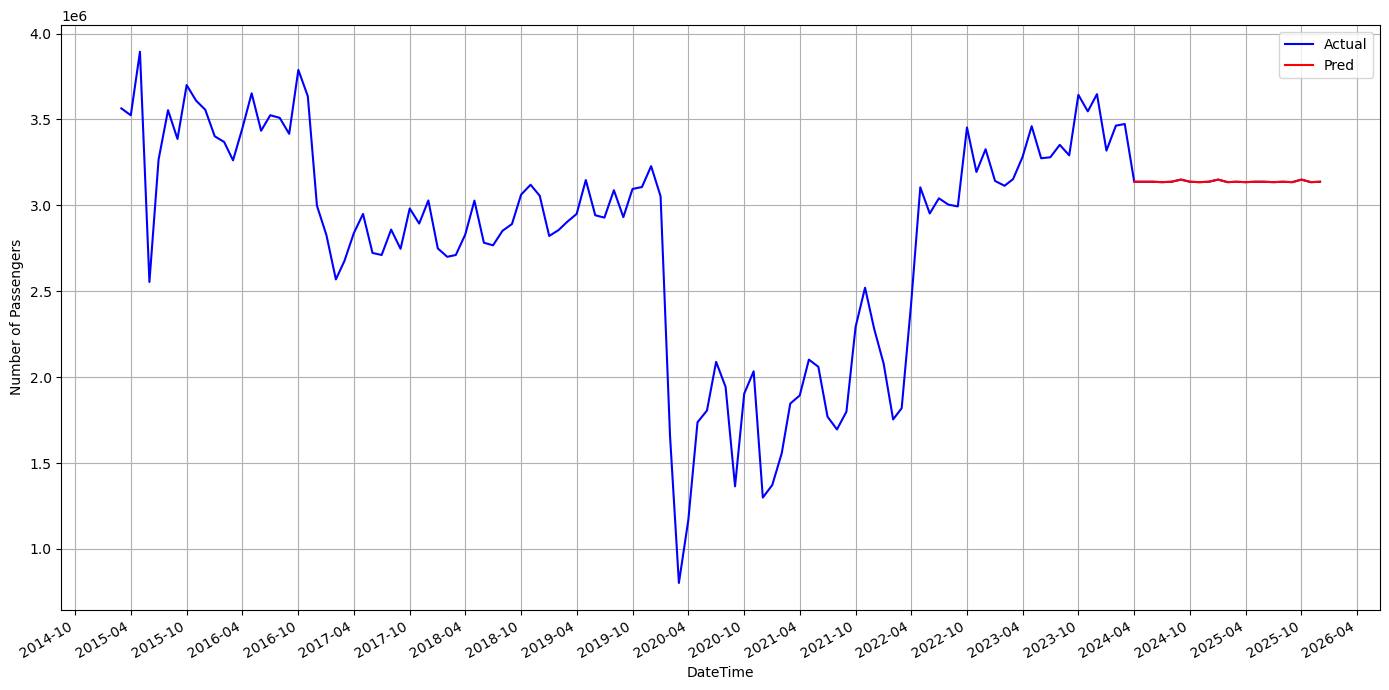

In [82]:
# 데이터 결합
combined_df = pd.concat([train_data, val_data, test_df], ignore_index=True)

# '운행년월' object 타입일 경우 datetime으로 변환
if combined_df['운행년월'].dtype == 'O':  
    combined_df['운행년월'] = pd.to_datetime(combined_df['운행년월'], format='%Y-%m')

combined_df['운행년월'] = combined_df['운행년월'].dt.to_period('M').dt.to_timestamp()

if test_df['운행년월'].dtype == 'O':
    test_df['운행년월'] = pd.to_datetime(test_df['운행년월'], format='%Y-%m')


if pd.api.types.is_period_dtype(test_df['운행년월']):
    test_df['운행년월'] = test_df['운행년월'].dt.to_timestamp()

# 시각화
plt.figure(figsize=(14, 7))

plt.plot(combined_df['운행년월'], combined_df['승차인원수'], linestyle='-', color='b', label='Actual')
plt.plot(test_df['운행년월'], test_df['승차인원수'], linestyle='-', color='r', label='Pred')
plt.xlabel('DateTime')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)

# X축 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))  # 6개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()